In [56]:
from graphviz import Digraph
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import copy
from random import shuffle as sl
from random import randint as rd
from IPython.display import Image

In [2]:
# 1st step: generate the directed acyclic graph
n = 20   #number of nodes
m = 20   #number of directed edges 

def gn():
    num = rd(1,1000)
    return num
def w2f(f,num,fg):
    f.write(str(num))
    if fg==True:
        f.write('\n')
    else:
        f.write(' ')

def DataMake(c):
   
    f = open('./data/data_{}_{}'.format(n,m)+"__"+str(c)+'.txt','w')
    
    node = list(range(1,n+1))
    sl(node)
    sl(node)
    
    w2f(f,n,0);w2f(f,m,1)
    edges=[]
    count=0
    while count<m:
        p1 = rd (1,n-1)
        p2 = rd (p1+1,n)
        x = node[p1-1]
        y = node[p2-1]
        if [x,y] not in edges:
            edges.append([x,y])
            w2f(f,x,0);w2f(f,y,1);
            count+=1
    print(n,' node',m,' edges')
    f.close()


In [3]:
# prepare data file for the DAG
c=1
DataMake(c)
print('Done')

20  node 20  edges
Done


In [4]:
#2nd step: visualize the graph(which is saved in fsm.gv.pdf). return a mat describing the graph structure
def vis_mat(c,n,m):
    f = Digraph('finite_state_machine', filename='fsm.gv')
    with f.subgraph() as s:
        s.attr(rank='same')
        f.attr('node', shape='circle')
        for i in range(n):
            f.node(str(i))

    # f.attr(rankdir='LR', size='8,5')

    file1 = open('./data/data_{}_{}'.format(n,m)+"__"+str(c)+'.txt',"r")  
    n,m=[int(x) for x in file1.readline().split()]

    f.attr('node', shape='circle')
    for i in range(n):
        f.node(str(i))

    mat=np.zeros([n]*2)
    f.attr('node', shape='circle')    
    for i in range(m):
        i,j=[int(x) for x in file1.readline().split()]
        f.edge(str(i-1), str(j-1))
        mat[j-1,i-1]=1
    #     print(i,j)

    f.view()    
    return mat

def only_mat(c,n,m):
    file1 = open('data_{}_{}'.format(n,m)+"__"+str(c)+'.txt',"r")  
    n,m=[int(x) for x in file1.readline().split()]
    mat=np.zeros([n]*2)
      
    for i in range(m):
        i,j=[int(x) for x in file1.readline().split()] 
        mat[j-1,i-1]=1
    return mat

#run the function and see the graph structure in the fsm.gv.pdf file. The mat matrix would be used later.
mat=vis_mat(c,n,m)

In [5]:
#prepare two dicts for later use. Generate the topological order of the nodes in DAG
def structure_data(mat):
    dic=dict()  #dict(key:node, value: list of the node's chidren)
    for j in range(n):
          s=dic.setdefault(str(j),[]);
          for i in range(n):
            if mat[i,j]!=0:
                dic[str(j)].append(i)
    print("children_dic:")
    print(dic)

    parents_dic=dict()  #dict(key:node, value:list of the node's parents)
    for i in range(n):
          s=parents_dic.setdefault(str(i),[]);
          for j in range(n):
            if mat[i,j]!=0:
                parents_dic[str(i)].append(j)

    print("parents_dic:")
    print(parents_dic)

    nodes=range(n)
    #generate topological order of the nodes(note topological order is not unique to a given directed acyclic graph)
    top_list=[]

    def child(j):
        while dic[str(j)] != [] and not set(dic[str(j)]).issubset(set(top_list)):
            for i in dic[str(j)]:
                while dic[str(i)] !=[] and not set(dic[str(i)]).issubset(set(top_list)):   
                    child(i)
                else:
                    if  i not in top_list: 
                        top_list.append(i)
    #                     print("top_list=",top_list)
        else:
            if j not in top_list:
                top_list.append(j)
    #             print("top_list=",top_list)

    for j in nodes:
         child(j)

    print('topological order of the nodes:')
    print(top_list)
    return dic, parents_dic, top_list

dic, parents_dic, top_list=structure_data(mat)

children_dic:
{'0': [], '1': [11, 18], '2': [15], '3': [0], '4': [], '5': [], '6': [9, 15], '7': [1], '8': [4], '9': [11], '10': [4, 6], '11': [0], '12': [3], '13': [11], '14': [], '15': [0], '16': [14, 15], '17': [4, 9], '18': [9], '19': []}
parents_dic:
{'0': [3, 11, 15], '1': [7], '2': [], '3': [12], '4': [8, 10, 17], '5': [], '6': [10], '7': [], '8': [], '9': [6, 17, 18], '10': [], '11': [1, 9, 13], '12': [], '13': [], '14': [16], '15': [2, 6, 16], '16': [], '17': [], '18': [1], '19': []}
topological order of the nodes:
[0, 11, 9, 18, 1, 15, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 19]


In [6]:
#3rd step: Enumerate paths:  produce all directed paths connecting two nodes V_i(node_label: start) to V_j(node_label: end).
def paths_given_two_nodes(dic,top_list, start, end):
    id_start=top_list.index(start)
    id_end=top_list.index(end)
    if id_start<=id_end:
        return []
    
    def add_path(new_node,path,paths):
        if top_list.index(new_node)>id_end:
            path.append(new_node)         
        elif top_list.index(new_node)==id_end:
            path.append(new_node)
            paths.append(copy.deepcopy(path))  #deepcopy is essential here!!
#             print('1',paths)    this print statement will produce strange result!!
            path.pop()
            return path,paths
        else:
            return path,paths
        
        for nn in dic[str(new_node)]:
            path,paths=add_path(nn,path,paths) 
        path.pop()
        return path,paths
    paths=[]
    path=[]
    path,paths=add_path(start,path,paths)
    if paths!=[]:
        print("the roads connecting {}th node to {}th node are:".format(start,end))
        print(paths)
    return paths

In [7]:
#run 3rd step:
paths=paths_given_two_nodes(dic,top_list,7,0)

the roads connecting 7th node to 0th node are:
[[7, 1, 11, 0], [7, 1, 18, 9, 11, 0]]


In [40]:
#4th step: Generate data according to the structure of the graph:
# def generate_data(n_sample,n,parents_dic):
#     Data=np.zeros((n_sample,n))
#     mod1=lambda num:np.random.normal(0,1,num)

#     for d in range(n_sample):
#         Data[d,:]=mod1(n)  # firstly: all nodes are assigned independent random numbers with distribution N(0,1) 
#         for i in range(n):
#             for j in parents_dic[str(i)]:
#                 Data[d,i]=Data[d,i]+Data[d,j]  #for nodes with parents, the parents variables are added
#     return Data
# n_sample=1000
# Data=generate_data(n_sample,n,parents_dic)

In [100]:
#revised 4th step: Generate data according to the structure of the graph:
def generate_data_revised(n_sample,n,parents_dic):
#     np.random.seed(a=1)
    Data=np.zeros((n_sample,n))
    mod1=lambda num:np.random.normal(0,1,num)

    for d in range(n_sample):
        Data[d,:]=mod1(n)  # firstly: all nodes are assigned independent random numbers with distribution N(0,1) 
        
        tol=set(range(n))
        father=set()
        while tol!=set():
            child=set()
            for i in tol:
                if set(parents_dic[str(i)]).issubset(father):
                    child.add(i) #for each step, identify the nodes to be modified
            for i in child:
                for j in parents_dic[str(i)]:
                #the nodes modified in an order that fathers always get modified earlier than children
                #which is a group-wise topological order
                    Data[d,i]=Data[d,i]+Data[d,j]            
            father=father.union(child)  
            tol=tol-father
#             print("child=",child)
    return Data
n_sample=1000
Data=generate_data_revised(n_sample,n,parents_dic)

In [102]:
#5th step: 
def feature_selection(Data, target, N_selected):
    
    df=pd.DataFrame(Data)
    y=df[target]
    X = df.drop([target], axis=1)
    
    reg = LassoCV(cv=5, random_state=0).fit(X, y)
    ss1=reg.score(X, y)
    print("Rsquare score with all features:",ss1) 

    #assign very low threshold as starting point
    clf=LassoCV(cv=5)
    sfm = SelectFromModel(clf, threshold=0.0001)
    s=sfm.fit(X, y)
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

    # Reset the threshold till the number of features equals two.
    while n_features > N_selected:
        sfm.threshold += 0.001
        X_transform = sfm.transform(X)
        n_features = X_transform.shape[1]
    #     print("threshold=",sfm.threshold, "n_features=",n_features)

    reg = LassoCV(cv=5, random_state=0).fit(X_transform, y)
    ss2=reg.score(X_transform, y)
    print("Rsquare Score with selected features:",ss2) 

    print("n_features=",n_features)
    print("target=",target)
    a=list(sfm.get_support())
    a.insert(target,False)
    selected=[i for i in range(len(a)) if a[i]]
    print("selected=",selected)
    return selected, ss1,ss2
    
target=6
N_selected=3
selected, ss1,ss2=feature_selection(Data, target, N_selected)


Rsquare score with all features: 0.8402468608061364
Rsquare Score with selected features: 0.5349825990165251
n_features= 3
target= 6
selected= [2, 15, 17]


### Nice examples of feature selection(refer to the specific Graph below):  
  - for target=15,  N_selected=6,  the selected nodes are: [0, 2, 3, 6, 11, 16], $R^2=0.9$
  - for target=9,  N_selected=6,  the selected nodes are: [1, 6, 11, 13, 17, 18], $R^2=0.92$     
  - for target=4,  N_selected=3,  the selected nodes are: [8, 10, 17],  $R^2=0.73$     
  - for target=10,   N_selected=4,  the selected nodes are: [4, 6, 8, 17],   $R^2<=0.7$
  - for target=7,   N_selected=1,  the selected nodes are: [1],   $R^2\approx0.5$

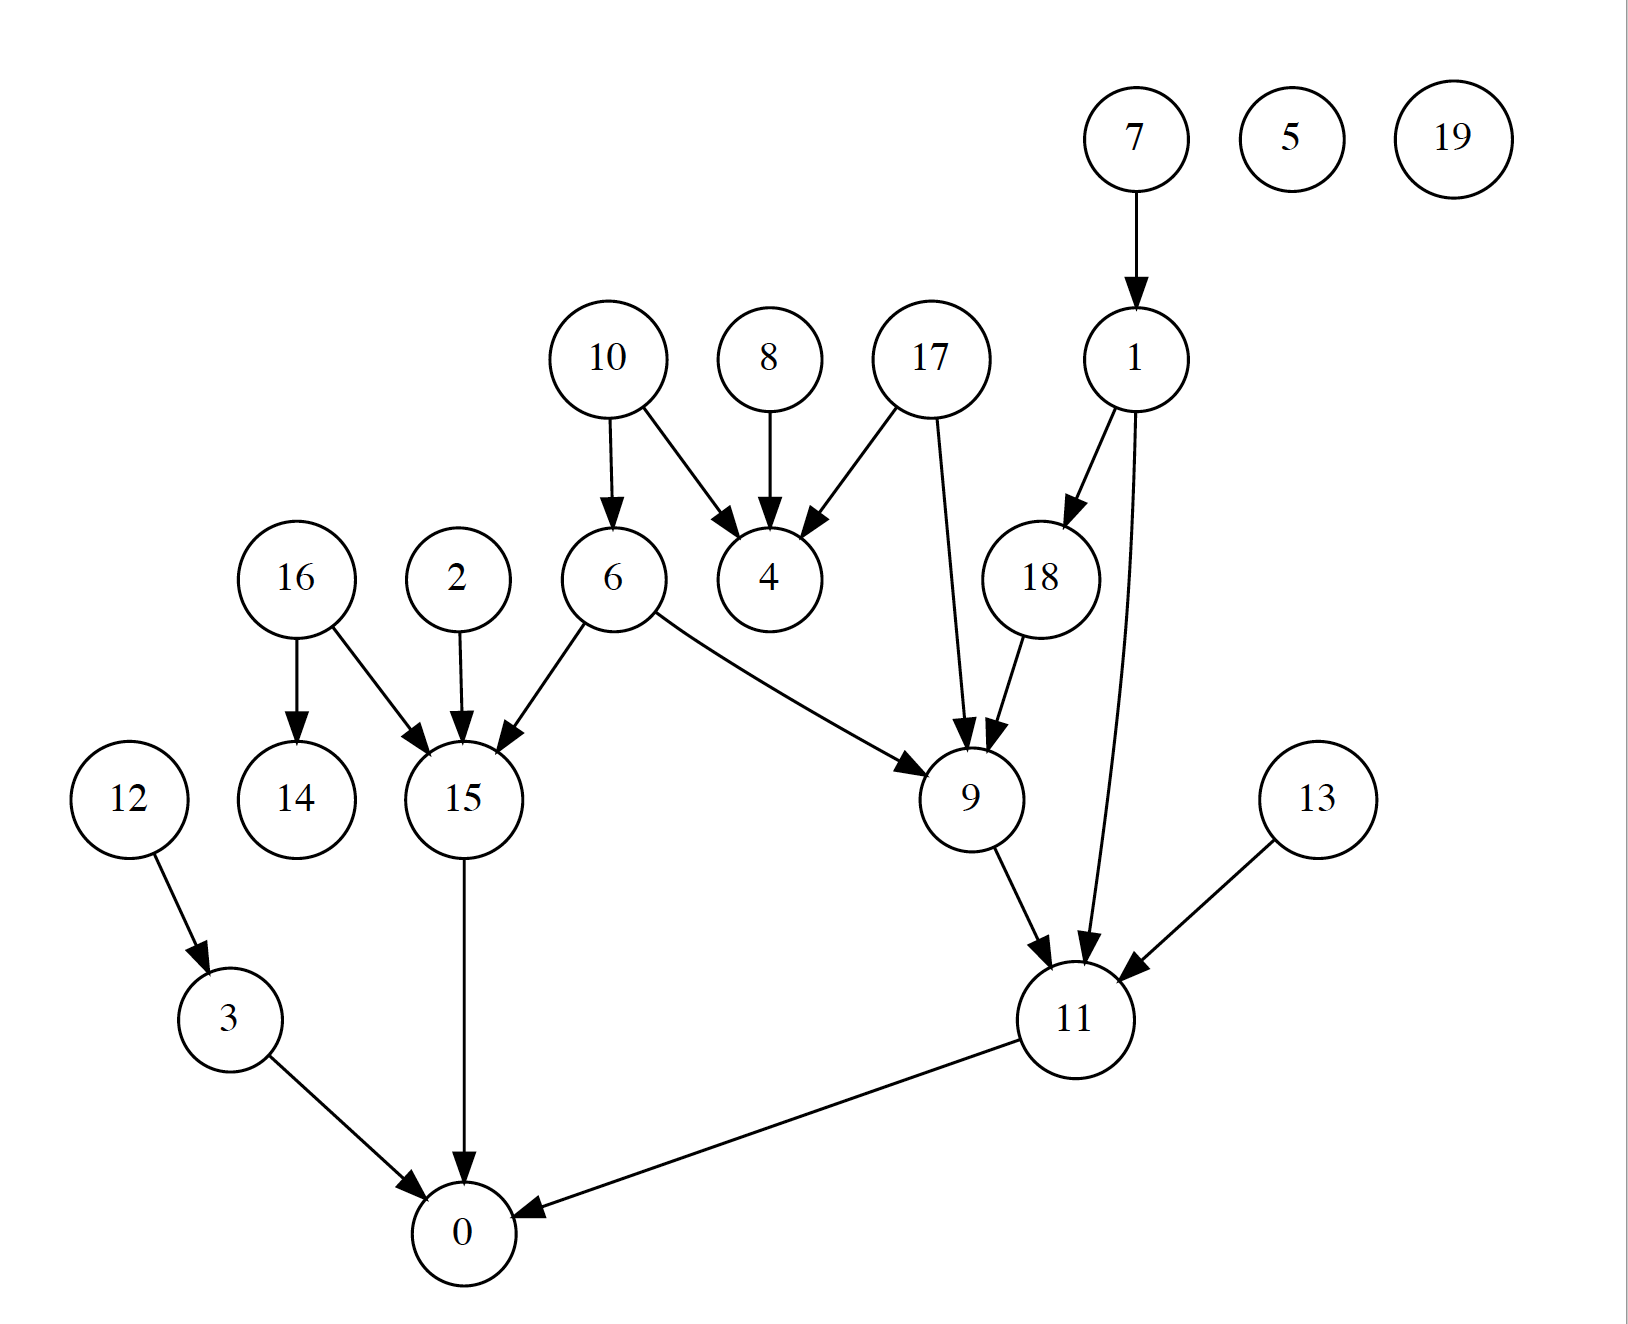

In [58]:
fig = Image(filename=('./DAG.png'))
fig

### One point on  probability distribution
- The data distribution for each node is centered around 0,  with different variance. For example, the 1st node has a variance $\sqrt{2}$, 8th node has variance $\sqrt{3}$ while 13rd node has variance 1.

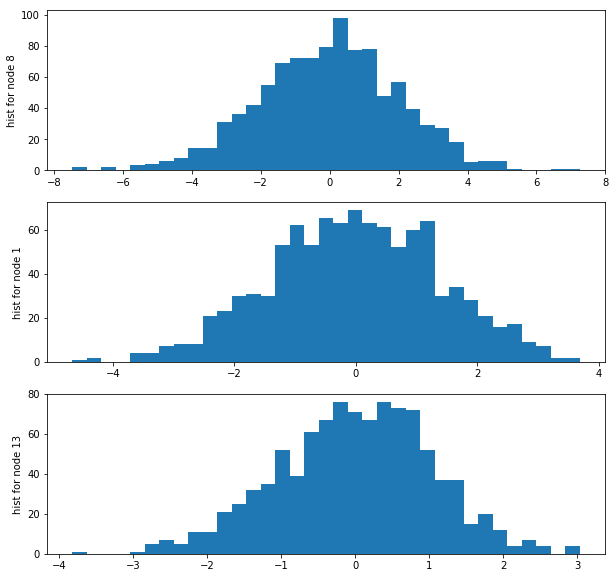

In [278]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3,1,1)
s=ax.hist( np.array(y),bins=35 ,)
s=ax.set_ylabel("hist for node {}".format(target));

ax = fig.add_subplot(3,1,2)
s=ax.hist( np.array(X[1]),bins=35 ,)
s=ax.set_ylabel("hist for node {}".format(1));

ax = fig.add_subplot(3,1,3)
s=ax.hist( np.array(X[13]),bins=35 ,)
s=ax.set_ylabel("hist for node {}".format(13));

## 6th step. 
- Now, let's generate 100 random graphs with n=20 nodes and m=20 edges. Then, calculate $R^2$ score for selected features. Based on some observations on calculated result, we would select L-distant-neighbours as features and try to see the L-dependence on the final hist-diagram.

In [374]:
result=[]

n=20
m=20
Ls=[1,2,3]
# c=1
for c in range(100):
    print("ccccccccccc=",c)
    DataMake(c)
    mat=only_mat(c,n,m)
    dic, parents_dic, top_list=structure_data(mat)

    # paths=paths_given_two_nodes(dic,top_list,18,6)

    n_sample=1000
    Data=generate_data(n_sample,n,parents_dic)


    def distance(i,j,dis):
        paths=paths_given_two_nodes(dic,top_list,i,j)+paths_given_two_nodes(dic,top_list,j,i)
        dis[(i,j)]=set([len(path)-1 for path in paths])
        dis[(j,i)]=set([len(path)-1 for path in paths])
        return dis

    dis=dict()
    for i in range(n):
        for j in range(i+1,n):
            dis=distance(i,j,dis)

    for L in Ls:        
        for i in range(n):
            target=i
            features=[]
            for j in list(range(i))+list(range(i+1,n)):
                if L in dis[(i,j)]:
                    features.append(j) 
            N_selected=len(features) 

            if N_selected>=2:
                selected, ss1,ss2=feature_selection(Data, target, N_selected)
                result.append((c,target,selected,N_selected,L,ss1,ss2))


ccccccccccc= 0
20  node 20  edges
children_dic:
{'0': [], '1': [18], '2': [], '3': [12], '4': [11], '5': [2], '6': [12], '7': [], '8': [11], '9': [2, 15], '10': [], '11': [9], '12': [], '13': [], '14': [9, 12], '15': [3, 12], '16': [3, 9, 12], '17': [11, 13], '18': [7], '19': [12]}
parents_dic:
{'0': [], '1': [], '2': [5, 9], '3': [15, 16], '4': [], '5': [], '6': [], '7': [18], '8': [], '9': [11, 14, 16], '10': [], '11': [4, 8, 17], '12': [3, 6, 14, 15, 16, 19], '13': [17], '14': [], '15': [9], '16': [], '17': [], '18': [1], '19': []}
topological order of the nodes:
[0, 7, 18, 1, 2, 12, 3, 15, 9, 11, 4, 5, 6, 8, 10, 13, 14, 16, 17, 19]
the roads connecting 1th node to 7th node are:
[[1, 18, 7]]
the roads connecting 1th node to 18th node are:
[[1, 18]]
the roads connecting 4th node to 2th node are:
[[4, 11, 9, 2]]
the roads connecting 5th node to 2th node are:
[[5, 2]]
the roads connecting 8th node to 2th node are:
[[8, 11, 9, 2]]
the roads connecting 9th node to 2th node are:
[[9, 2]]


Rsquare score with all features: 0.7965429358495789
Rsquare Score with selected features: 0.6701870772578833
n_features= 3
target= 0
selected= [1, 8, 12]
Rsquare score with all features: 0.837984637359457
Rsquare Score with selected features: 0.7554134101130171
n_features= 3
target= 1
selected= [0, 7, 15]
Rsquare score with all features: 0.8005676283338206
Rsquare Score with selected features: 0.5793758583302604
n_features= 3
target= 2
selected= [1, 8, 19]
Rsquare score with all features: 0.7649596782484254
Rsquare Score with selected features: 0.5425335274028817
n_features= 3
target= 5
selected= [6, 11, 13]
Rsquare score with all features: 0.8555437319772532
Rsquare Score with selected features: 0.6952167883818359
n_features= 2
target= 6
selected= [11, 13]
Rsquare score with all features: 0.6792423547976327
Rsquare Score with selected features: 0.5100249359216049
n_features= 2
target= 7
selected= [1, 15]
Rsquare score with all features: 0.7514323253896018
Rsquare Score with selected f

Rsquare Score with selected features: 0.6666606663081912
n_features= 2
target= 8
selected= [6, 17]
Rsquare score with all features: 0.8626121350330074
Rsquare Score with selected features: 0.45797369965074675
n_features= 2
target= 11
selected= [6, 19]
Rsquare score with all features: 0.8701298258319018
Rsquare Score with selected features: 0.8060547178496767
n_features= 2
target= 12
selected= [1, 5]
Rsquare score with all features: 0.9478094655159427
Rsquare Score with selected features: 0.9477389382359583
n_features= 5
target= 17
selected= [0, 5, 8, 11, 19]
Rsquare score with all features: 0.7513342167446966
Rsquare Score with selected features: 0.35275566107634226
n_features= 2
target= 1
selected= [12, 19]
Rsquare score with all features: 0.7264716951464474
Rsquare Score with selected features: 0.6395590566026244
n_features= 2
target= 6
selected= [8, 11]
Rsquare score with all features: 0.9478094655159427
Rsquare Score with selected features: 0.7326849014094428
n_features= 2
target= 

Rsquare Score with selected features: 0.5886773952491515
n_features= 2
target= 13
selected= [10, 15]
Rsquare score with all features: 0.8858787937917074
Rsquare Score with selected features: 0.7737846479610644
n_features= 3
target= 17
selected= [0, 10, 14]
ccccccccccc= 4
20  node 20  edges
children_dic:
{'0': [4, 10], '1': [4, 10], '2': [], '3': [], '4': [], '5': [4], '6': [4], '7': [6], '8': [6], '9': [12], '10': [5], '11': [1, 5, 6], '12': [16, 18], '13': [], '14': [17], '15': [], '16': [1, 4, 5], '17': [], '18': [], '19': [4]}
parents_dic:
{'0': [], '1': [11, 16], '2': [], '3': [], '4': [0, 1, 5, 6, 16, 19], '5': [10, 11, 16], '6': [7, 8, 11], '7': [], '8': [], '9': [], '10': [0, 1], '11': [], '12': [9], '13': [], '14': [], '15': [], '16': [12], '17': [14], '18': [12], '19': []}
topological order of the nodes:
[4, 5, 10, 0, 1, 2, 3, 6, 7, 8, 16, 18, 12, 9, 11, 13, 17, 14, 15, 19]
the roads connecting 0th node to 4th node are:
[[0, 4], [0, 10, 5, 4]]
the roads connecting 0th node to 

Rsquare score with all features: 0.8715106586435176
Rsquare Score with selected features: 0.5214270598695402
n_features= 3
target= 0
selected= [5, 13, 16]
Rsquare score with all features: 0.7413208431232545
Rsquare Score with selected features: 0.7399822218060228
n_features= 2
target= 2
selected= [0, 13]
Rsquare score with all features: 0.8908329795300879
Rsquare Score with selected features: 0.6773880736849992
n_features= 3
target= 5
selected= [0, 11, 16]
Rsquare score with all features: 0.8184173008122013
Rsquare Score with selected features: 0.7439278836740826
n_features= 3
target= 7
selected= [0, 3, 13]
Rsquare score with all features: 0.6442845664888753
Rsquare Score with selected features: 0.3247275902164547
n_features= 2
target= 11
selected= [5, 6]
Rsquare score with all features: 0.8840848954369653
Rsquare Score with selected features: 0.7309168168157651
n_features= 7
target= 12
selected= [0, 3, 5, 9, 11, 16, 18]
Rsquare score with all features: 0.7443212451210497
Rsquare Score

Rsquare Score with selected features: 0.8129691615395976
n_features= 2
target= 3
selected= [17, 19]
Rsquare score with all features: 0.7621441825832312
Rsquare Score with selected features: 0.6704183325474209
n_features= 2
target= 9
selected= [8, 10]
Rsquare score with all features: 0.9069319942343388
Rsquare Score with selected features: 0.7361900978920607
n_features= 2
target= 10
selected= [9, 18]
Rsquare score with all features: 0.7701373389788814
Rsquare Score with selected features: 0.7665344857430879
n_features= 2
target= 14
selected= [3, 13]
Rsquare score with all features: 0.929469331004017
Rsquare Score with selected features: 0.7487337110339715
n_features= 4
target= 15
selected= [3, 6, 12, 19]
Rsquare score with all features: 0.8888603574106579
Rsquare Score with selected features: 0.6547908137993722
n_features= 2
target= 18
selected= [10, 16]
Rsquare score with all features: 0.7621441825832312
Rsquare Score with selected features: 0.6704183325474209
n_features= 2
target= 9
s

Rsquare Score with selected features: 0.8927925593942132
n_features= 3
target= 19
selected= [9, 14, 16]
Rsquare score with all features: 0.6766357638131365
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [5, 8]
Rsquare score with all features: 0.8939802458435635
Rsquare Score with selected features: 0.664868957847442
n_features= 2
target= 5
selected= [8, 9]
Rsquare score with all features: 0.810422058383711
Rsquare Score with selected features: 0.6249243754355611
n_features= 2
target= 6
selected= [4, 13]
Rsquare score with all features: 0.9177313935275326
Rsquare Score with selected features: 0.0
n_features= 2
target= 7
selected= [11, 13]
Rsquare score with all features: 0.7482139036338102
Rsquare Score with selected features: 0.47941054432508434
n_features= 2
target= 8
selected= [5, 9]
Rsquare score with all features: 0.8506790065799528
Rsquare Score with selected features: 0.5068186546781583
n_features= 2
target= 9
selected= [5, 8]
Rsquare score with all f

Rsquare Score with selected features: 0.7997238685331454
n_features= 4
target= 0
selected= [2, 7, 13, 16]
Rsquare score with all features: 0.5281127144206377
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [18, 19]
Rsquare score with all features: 0.8465684712430906
Rsquare Score with selected features: 0.5858532084207801
n_features= 3
target= 2
selected= [0, 12, 13]
Rsquare score with all features: 0.7570169293801334
Rsquare Score with selected features: 0.6891001169064095
n_features= 3
target= 5
selected= [0, 12, 19]
Rsquare score with all features: 0.919461332122218
Rsquare Score with selected features: 0.7493283748328092
n_features= 3
target= 7
selected= [0, 14, 16]
Rsquare score with all features: 0.8482786721358577
Rsquare Score with selected features: 0.6336159537403745
n_features= 4
target= 8
selected= [10, 15, 18, 19]
Rsquare score with all features: 0.6612860364520903
Rsquare Score with selected features: 0.45089652426455357
n_features= 4
target= 1

Rsquare Score with selected features: 0.26301386569508056
n_features= 4
target= 8
selected= [4, 5, 7, 16]
Rsquare score with all features: 0.8368089506465889
Rsquare Score with selected features: 0.5201622335172091
n_features= 2
target= 10
selected= [4, 5]
Rsquare score with all features: 0.8036653178136783
Rsquare Score with selected features: 0.0
n_features= 3
target= 13
selected= [5, 10, 18]
Rsquare score with all features: 0.9115888270297732
Rsquare Score with selected features: 0.8637517715598891
n_features= 4
target= 14
selected= [0, 9, 13, 17]
Rsquare score with all features: 0.8925281821303132
Rsquare Score with selected features: 0.8335131460997907
n_features= 2
target= 16
selected= [7, 8]
Rsquare score with all features: 0.7607935320617036
Rsquare Score with selected features: 0.5930971492607945
n_features= 2
target= 4
selected= [9, 10]
Rsquare score with all features: 0.759217697372086
Rsquare Score with selected features: 0.262304490651903
n_features= 3
target= 8
selected= 

Rsquare score with all features: 0.7471622234100392
Rsquare Score with selected features: 0.0
n_features= 2
target= 0
selected= [2, 8]
Rsquare score with all features: 0.8269796113687984
Rsquare Score with selected features: 0.6420961495999176
n_features= 2
target= 2
selected= [7, 16]
Rsquare score with all features: 0.653681083297847
Rsquare Score with selected features: 0.48287796594081145
n_features= 2
target= 3
selected= [9, 13]
Rsquare score with all features: 0.8940948577005762
Rsquare Score with selected features: 0.7896544807727413
n_features= 4
target= 5
selected= [9, 12, 14, 19]
Rsquare score with all features: 0.8418310142138825
Rsquare Score with selected features: 0.6659814581503435
n_features= 2
target= 7
selected= [2, 16]
Rsquare score with all features: 0.7927026128103816
Rsquare Score with selected features: 0.35071935200183724
n_features= 3
target= 8
selected= [0, 2, 16]
Rsquare score with all features: 0.8402104043974994
Rsquare Score with selected features: 0.782004

Rsquare Score with selected features: 0.5143744660557517
n_features= 2
target= 18
selected= [4, 16]
Rsquare score with all features: 0.7651359928652862
Rsquare Score with selected features: 0.5158542252337814
n_features= 2
target= 4
selected= [1, 18]
Rsquare score with all features: 0.9407719653232561
Rsquare Score with selected features: 0.940859448692336
n_features= 5
target= 13
selected= [5, 6, 7, 8, 11]
Rsquare score with all features: 0.7961337758726675
Rsquare Score with selected features: 0.7946964172590965
n_features= 4
target= 15
selected= [2, 5, 11, 17]
ccccccccccc= 13
20  node 20  edges
children_dic:
{'0': [14, 18], '1': [7], '2': [8, 13], '3': [1, 6, 7, 14, 16], '4': [8], '5': [], '6': [4], '7': [], '8': [], '9': [16], '10': [], '11': [6], '12': [2, 3], '13': [7], '14': [4], '15': [], '16': [8], '17': [], '18': [], '19': [12]}
parents_dic:
{'0': [], '1': [3], '2': [12], '3': [12], '4': [6, 14], '5': [], '6': [3, 11], '7': [1, 3, 13], '8': [2, 4, 16], '9': [], '10': [], '11'

children_dic:
{'0': [2, 10], '1': [3, 18], '2': [15, 19], '3': [15], '4': [6, 13, 19], '5': [], '6': [14], '7': [], '8': [19], '9': [], '10': [], '11': [], '12': [], '13': [], '14': [10], '15': [10], '16': [5, 10, 13], '17': [3], '18': [10], '19': [10]}
parents_dic:
{'0': [], '1': [], '2': [0], '3': [1, 17], '4': [], '5': [16], '6': [4], '7': [], '8': [], '9': [], '10': [0, 14, 15, 16, 18, 19], '11': [], '12': [], '13': [4, 16], '14': [6], '15': [2, 3], '16': [], '17': [], '18': [1], '19': [2, 4, 8]}
topological order of the nodes:
[10, 15, 19, 2, 0, 3, 18, 1, 14, 6, 13, 4, 5, 7, 8, 9, 11, 12, 16, 17]
the roads connecting 0th node to 2th node are:
[[0, 2]]
the roads connecting 0th node to 10th node are:
[[0, 2, 15, 10], [0, 2, 19, 10], [0, 10]]
the roads connecting 0th node to 15th node are:
[[0, 2, 15]]
the roads connecting 0th node to 19th node are:
[[0, 2, 19]]
the roads connecting 1th node to 3th node are:
[[1, 3]]
the roads connecting 1th node to 10th node are:
[[1, 3, 15, 10], [1

Rsquare score with all features: 0.9421626726069744
Rsquare Score with selected features: 0.9055561832693348
n_features= 5
target= 1
selected= [4, 9, 12, 16, 19]
Rsquare score with all features: 0.6852355659298109
Rsquare Score with selected features: 0.3578448021443137
n_features= 2
target= 4
selected= [1, 16]
Rsquare score with all features: 0.65944441441448
Rsquare Score with selected features: 0.660553701210572
n_features= 2
target= 5
selected= [9, 18]
Rsquare score with all features: 0.7982245122171603
Rsquare Score with selected features: 0.3113530904348609
n_features= 2
target= 6
selected= [14, 17]
Rsquare score with all features: 0.7483502186485734
Rsquare Score with selected features: 0.5144922489076128
n_features= 2
target= 9
selected= [1, 19]
Rsquare score with all features: 0.6453658001341388
Rsquare Score with selected features: 0.6455612006589364
n_features= 2
target= 10
selected= [12, 17]
Rsquare score with all features: 0.7559813268234116
Rsquare Score with selected fea

Rsquare Score with selected features: 0.7977145234521786
n_features= 2
target= 4
selected= [2, 5]
Rsquare score with all features: 0.7399836543077893
Rsquare Score with selected features: 0.7407309183765582
n_features= 2
target= 6
selected= [11, 18]
Rsquare score with all features: 0.7924540761667558
Rsquare Score with selected features: 0.6550050724094388
n_features= 3
target= 11
selected= [9, 14, 19]
Rsquare score with all features: 0.833117776479161
Rsquare Score with selected features: 0.6715453906650306
n_features= 3
target= 16
selected= [13, 17, 19]
ccccccccccc= 17
20  node 20  edges
children_dic:
{'0': [5], '1': [8], '2': [], '3': [], '4': [5, 6, 11], '5': [19], '6': [10, 12], '7': [8], '8': [3], '9': [14], '10': [], '11': [10], '12': [], '13': [0, 3], '14': [3], '15': [3, 10, 12], '16': [], '17': [2, 10], '18': [], '19': []}
parents_dic:
{'0': [13], '1': [], '2': [17], '3': [8, 13, 14, 15], '4': [], '5': [0, 4], '6': [4], '7': [], '8': [1, 7], '9': [], '10': [6, 11, 15, 17], '1

Rsquare Score with selected features: 0.40984394239840394
n_features= 3
target= 6
selected= [8, 10, 14]
Rsquare score with all features: 0.9178712295987258
Rsquare Score with selected features: 0.83851140314621
n_features= 4
target= 9
selected= [0, 7, 8, 12]
Rsquare score with all features: 0.7607002523684347
Rsquare Score with selected features: 0.5012150064228571
n_features= 2
target= 10
selected= [4, 14]
Rsquare score with all features: 0.8887226344411204
Rsquare Score with selected features: 0.6639734459553481
n_features= 2
target= 12
selected= [8, 9]
Rsquare score with all features: 0.752792834999008
Rsquare Score with selected features: 0.6186560909102488
n_features= 2
target= 14
selected= [6, 8]
Rsquare score with all features: 0.7559550520700217
Rsquare Score with selected features: 0.5203557972377824
n_features= 2
target= 16
selected= [3, 4]
Rsquare score with all features: 0.826773477834095
Rsquare Score with selected features: 0.8247333422542128
n_features= 3
target= 17
sele

Rsquare Score with selected features: 0.4835290497639243
n_features= 2
target= 8
selected= [6, 11]
Rsquare score with all features: 0.9238799998925932
Rsquare Score with selected features: 0.6456970337290864
n_features= 3
target= 11
selected= [5, 6, 8]
Rsquare score with all features: 0.6532844104609464
Rsquare Score with selected features: 0.5211295920360963
n_features= 2
target= 14
selected= [0, 3]
Rsquare score with all features: 0.7118793965277911
Rsquare Score with selected features: 0.46922072896803124
n_features= 2
target= 18
selected= [9, 11]
Rsquare score with all features: 0.9346918900103962
Rsquare Score with selected features: 0.9344840210517712
n_features= 4
target= 3
selected= [2, 4, 14, 18]
Rsquare score with all features: 0.9126097547832491
Rsquare Score with selected features: 0.9108660200652322
n_features= 7
target= 4
selected= [0, 3, 5, 6, 7, 8, 11]
Rsquare score with all features: 0.8201859076315776
Rsquare Score with selected features: 0.47867014544380315
n_feature

Rsquare Score with selected features: 0.6914958589105529
n_features= 3
target= 0
selected= [4, 11, 14]
Rsquare score with all features: 0.8110236105632994
Rsquare Score with selected features: 0.6980950199753537
n_features= 3
target= 3
selected= [4, 10, 15]
Rsquare score with all features: 0.8920102674991606
Rsquare Score with selected features: 0.6691824235635566
n_features= 3
target= 4
selected= [0, 14, 15]
Rsquare score with all features: 0.7246962914016086
Rsquare Score with selected features: 0.0
n_features= 2
target= 6
selected= [0, 4]
Rsquare score with all features: 0.7344711081600465
Rsquare Score with selected features: 0.39794496814770686
n_features= 2
target= 8
selected= [11, 19]
Rsquare score with all features: 0.8973924714905775
Rsquare Score with selected features: 0.6026892682944773
n_features= 4
target= 10
selected= [0, 3, 4, 19]
Rsquare score with all features: 0.9214693765322227
Rsquare Score with selected features: 0.7760670004047869
n_features= 3
target= 11
selecte

Rsquare score with all features: 0.7641813644913137
Rsquare Score with selected features: 0.5304334131073463
n_features= 3
target= 4
selected= [3, 11, 12]
Rsquare score with all features: 0.9175241584952327
Rsquare Score with selected features: 0.8040778297240833
n_features= 2
target= 12
selected= [4, 16]
Rsquare score with all features: 0.48680071177364953
Rsquare Score with selected features: 0.4788318509200374
n_features= 2
target= 14
selected= [11, 17]
Rsquare score with all features: 0.9711197254921227
Rsquare Score with selected features: 0.9296828717587988
n_features= 5
target= 16
selected= [3, 9, 11, 12, 13]
Rsquare score with all features: 0.49111220272741873
Rsquare Score with selected features: 0.481634770451975
n_features= 2
target= 17
selected= [11, 14]
Rsquare score with all features: 0.9711197254921227
Rsquare Score with selected features: 0.8243841261194336
n_features= 2
target= 16
selected= [3, 12]
ccccccccccc= 23
20  node 20  edges
children_dic:
{'0': [9, 11], '1': [7

Rsquare score with all features: 0.66944564608532
Rsquare Score with selected features: 0.48265849819618967
n_features= 2
target= 0
selected= [15, 16]
Rsquare score with all features: 0.6711083670251456
Rsquare Score with selected features: 0.669361561813957
n_features= 2
target= 1
selected= [8, 16]
Rsquare score with all features: 0.8073349128910355
Rsquare Score with selected features: 0.8029642426338717
n_features= 4
target= 5
selected= [3, 8, 14, 15]
Rsquare score with all features: 0.8460076565372978
Rsquare Score with selected features: 0.5886397691610405
n_features= 3
target= 7
selected= [12, 18, 19]
Rsquare score with all features: 0.8040624423133904
Rsquare Score with selected features: 0.5358587338512473
n_features= 3
target= 8
selected= [7, 12, 18]
Rsquare score with all features: 0.8245158951816068
Rsquare Score with selected features: 0.7625735464140178
n_features= 3
target= 9
selected= [7, 12, 17]
Rsquare score with all features: 0.7510829778661521
Rsquare Score with sele

Rsquare score with all features: 0.686645299833396
Rsquare Score with selected features: 0.3389000855780998
n_features= 2
target= 0
selected= [3, 15]
Rsquare score with all features: 0.8715106974028037
Rsquare Score with selected features: 0.7259834319372644
n_features= 5
target= 1
selected= [10, 14, 16, 18, 19]
Rsquare score with all features: 0.9139459895090514
Rsquare Score with selected features: 0.6606338149997575
n_features= 5
target= 2
selected= [0, 3, 12, 15, 18]
Rsquare score with all features: 0.9192208883319537
Rsquare Score with selected features: 0.8821242045959753
n_features= 5
target= 3
selected= [0, 2, 12, 15, 18]
Rsquare score with all features: 0.8652156039424296
Rsquare Score with selected features: 0.5209897749175467
n_features= 4
target= 11
selected= [3, 12, 15, 19]
Rsquare score with all features: 0.8885698388794175
Rsquare Score with selected features: 0.5672184627720565
n_features= 2
target= 14
selected= [10, 16]
Rsquare score with all features: 0.70344517530626

Rsquare Score with selected features: 0.4837754286651702
n_features= 2
target= 0
selected= [6, 15]
Rsquare score with all features: 0.7473606617142463
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [6, 7]
Rsquare score with all features: 0.826015218080802
Rsquare Score with selected features: 0.8238816006352887
n_features= 8
target= 3
selected= [0, 1, 2, 5, 6, 9, 12, 15]
Rsquare score with all features: 0.7527110041818743
Rsquare Score with selected features: 0.27923979283782663
n_features= 2
target= 7
selected= [17, 18]
Rsquare score with all features: 0.7562261763173879
Rsquare Score with selected features: 0.004150716844443902
n_features= 2
target= 9
selected= [0, 6]
Rsquare score with all features: 0.9165901515832142
Rsquare Score with selected features: 0.4809110643997252
n_features= 5
target= 12
selected= [0, 5, 6, 9, 15]
Rsquare score with all features: 0.6893908693003905
Rsquare Score with selected features: 0.2811893514173536
n_features= 2
target= 

children_dic:
{'0': [8, 16], '1': [9], '2': [16], '3': [], '4': [1, 6], '5': [], '6': [16], '7': [], '8': [], '9': [8], '10': [16, 19], '11': [1, 7], '12': [1], '13': [], '14': [11], '15': [6, 7, 17, 19], '16': [], '17': [12], '18': [], '19': [8]}
parents_dic:
{'0': [], '1': [4, 11, 12], '2': [], '3': [], '4': [], '5': [], '6': [4, 15], '7': [11, 15], '8': [0, 9, 19], '9': [1], '10': [], '11': [14], '12': [17], '13': [], '14': [], '15': [], '16': [0, 2, 6, 10], '17': [15], '18': [], '19': [10, 15]}
topological order of the nodes:
[8, 16, 0, 9, 1, 2, 3, 6, 4, 5, 7, 19, 10, 11, 12, 13, 14, 17, 15, 18]
the roads connecting 0th node to 8th node are:
[[0, 8]]
the roads connecting 0th node to 16th node are:
[[0, 16]]
the roads connecting 4th node to 1th node are:
[[4, 1]]
the roads connecting 1th node to 8th node are:
[[1, 9, 8]]
the roads connecting 1th node to 9th node are:
[[1, 9]]
the roads connecting 11th node to 1th node are:
[[11, 1]]
the roads connecting 12th node to 1th node are:
[[

Rsquare Score with selected features: 0.7515598430670531
n_features= 3
target= 0
selected= [6, 15, 18]
Rsquare score with all features: 0.658871711323914
Rsquare Score with selected features: 0.6602018526831245
n_features= 3
target= 4
selected= [9, 16, 18]
Rsquare score with all features: 0.7409594263092092
Rsquare Score with selected features: 0.4904368757894966
n_features= 2
target= 5
selected= [1, 17]
Rsquare score with all features: 0.8433233041717921
Rsquare Score with selected features: 0.0
n_features= 2
target= 7
selected= [15, 17]
Rsquare score with all features: 0.8290041379664128
Rsquare Score with selected features: 0.5045855261676386
n_features= 4
target= 11
selected= [3, 5, 7, 17]
Rsquare score with all features: 0.8182533419506417
Rsquare Score with selected features: 0.002912176139046374
n_features= 2
target= 12
selected= [7, 15]
Rsquare score with all features: 0.7505372274721007
Rsquare Score with selected features: 0.5320127221743356
n_features= 2
target= 13
selected=

Rsquare Score with selected features: 0.48907701996583064
n_features= 2
target= 3
selected= [7, 16]
Rsquare score with all features: 0.966652801453848
Rsquare Score with selected features: 0.9465950567105158
n_features= 4
target= 4
selected= [0, 2, 5, 12]
Rsquare score with all features: 0.8284008415471934
Rsquare Score with selected features: 0.6538473639491854
n_features= 2
target= 5
selected= [4, 12]
Rsquare score with all features: 0.7711615264522518
Rsquare Score with selected features: 0.5384693396856199
n_features= 2
target= 6
selected= [10, 16]
Rsquare score with all features: 0.7448776381065674
Rsquare Score with selected features: 0.48196105548054824
n_features= 2
target= 8
selected= [10, 14]
Rsquare score with all features: 0.764760876518872
Rsquare Score with selected features: 0.5246143957599926
n_features= 2
target= 9
selected= [10, 14]
Rsquare score with all features: 0.9315959769816795
Rsquare Score with selected features: 0.8747417586371855
n_features= 5
target= 10
sel

Rsquare Score with selected features: 0.7597086961020556
n_features= 3
target= 4
selected= [1, 10, 14]
Rsquare score with all features: 0.8734062129707627
Rsquare Score with selected features: 0.6649560948621673
n_features= 2
target= 7
selected= [1, 16]
Rsquare score with all features: 0.7854729504319212
Rsquare Score with selected features: 0.5470425698571265
n_features= 2
target= 8
selected= [13, 19]
Rsquare score with all features: 0.7552787011736556
Rsquare Score with selected features: 0.7550005957384319
n_features= 2
target= 9
selected= [8, 13]
Rsquare score with all features: 0.658542114157338
Rsquare Score with selected features: 0.2852915316746816
n_features= 2
target= 11
selected= [4, 15]
Rsquare score with all features: 0.7591234419430704
Rsquare Score with selected features: 0.6627219304582594
n_features= 2
target= 13
selected= [8, 19]
Rsquare score with all features: 0.8429317182211238
Rsquare Score with selected features: 0.5815748517784616
n_features= 4
target= 14
select

Rsquare Score with selected features: -2.220446049250313e-16
n_features= 2
target= 15
selected= [0, 7]
Rsquare score with all features: 0.8323749293380776
Rsquare Score with selected features: 0.4908913081275085
n_features= 3
target= 18
selected= [1, 4, 11]
Rsquare score with all features: 0.7486142887348416
Rsquare Score with selected features: 0.0014825467453650765
n_features= 2
target= 0
selected= [7, 15]
Rsquare score with all features: 0.8411433793906619
Rsquare Score with selected features: 0.6744623355957071
n_features= 2
target= 1
selected= [2, 5]
Rsquare score with all features: 0.903074027995568
Rsquare Score with selected features: 0.7150678580140997
n_features= 4
target= 8
selected= [1, 3, 14, 15]
Rsquare score with all features: 0.9169187665417688
Rsquare Score with selected features: 0.9166808860956414
n_features= 9
target= 9
selected= [0, 3, 4, 7, 11, 12, 14, 15, 18]
Rsquare score with all features: 0.7436496224326288
Rsquare Score with selected features: 0.4914376233467

Rsquare Score with selected features: 0.9291722232505715
n_features= 4
target= 17
selected= [3, 5, 7, 9]
Rsquare score with all features: 0.7689786936096034
Rsquare Score with selected features: 0.37956738489744346
n_features= 2
target= 3
selected= [9, 14]
Rsquare score with all features: 0.8892760797473336
Rsquare Score with selected features: 0.8866871965352209
n_features= 3
target= 15
selected= [1, 11, 16]
ccccccccccc= 35
20  node 20  edges
children_dic:
{'0': [], '1': [12], '2': [4], '3': [0, 9], '4': [11, 19], '5': [], '6': [8], '7': [4, 18], '8': [0, 4], '9': [], '10': [], '11': [], '12': [5, 14], '13': [], '14': [5, 10], '15': [2], '16': [], '17': [0, 18], '18': [11], '19': [11]}
parents_dic:
{'0': [3, 8, 17], '1': [], '2': [15], '3': [], '4': [2, 7, 8], '5': [12, 14], '6': [], '7': [], '8': [6], '9': [3], '10': [14], '11': [4, 18, 19], '12': [1], '13': [], '14': [12], '15': [], '16': [], '17': [], '18': [7, 17], '19': [4]}
topological order of the nodes:
[0, 5, 10, 14, 12, 1, 1

Rsquare Score with selected features: 0.6139911005915943
n_features= 3
target= 0
selected= [1, 3, 16]
Rsquare score with all features: 0.6900433621478325
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [0, 16]
Rsquare score with all features: 0.8372261983058031
Rsquare Score with selected features: 0.7687362269406444
n_features= 3
target= 2
selected= [0, 5, 8]
Rsquare score with all features: 0.6956658736392243
Rsquare Score with selected features: 0.694284717692142
n_features= 2
target= 3
selected= [0, 19]
Rsquare score with all features: 0.7677498865566348
Rsquare Score with selected features: 0.5741839450634891
n_features= 2
target= 4
selected= [15, 17]
Rsquare score with all features: 0.7605177141180314
Rsquare Score with selected features: 0.7610092285386207
n_features= 3
target= 6
selected= [11, 12, 16]
Rsquare score with all features: 0.934544432320271
Rsquare Score with selected features: 0.753060810565938
n_features= 4
target= 8
selected= [1, 2, 4, 

Rsquare Score with selected features: 0.6810481695699688
n_features= 2
target= 12
selected= [8, 10]
Rsquare score with all features: 0.8941707834753796
Rsquare Score with selected features: 0.6626376877548049
n_features= 3
target= 15
selected= [1, 10, 17]
Rsquare score with all features: 0.8784674110910288
Rsquare Score with selected features: 0.46773520520050005
n_features= 3
target= 17
selected= [10, 18, 19]
Rsquare score with all features: 0.9547479631869674
Rsquare Score with selected features: 0.8733338620916601
n_features= 3
target= 19
selected= [10, 17, 18]
Rsquare score with all features: 0.767290401578235
Rsquare Score with selected features: 0.3923121850954746
n_features= 2
target= 0
selected= [3, 17]
Rsquare score with all features: 0.9171545136846638
Rsquare Score with selected features: 0.5945801760509946
n_features= 2
target= 10
selected= [17, 19]
Rsquare score with all features: 0.822663378902423
Rsquare Score with selected features: 0.0025510759045651588
n_features= 2
t

Rsquare Score with selected features: 0.8040100478609661
n_features= 6
target= 0
selected= [3, 7, 8, 12, 17, 18]
Rsquare score with all features: 0.7695415624617407
Rsquare Score with selected features: 0.49359896367220435
n_features= 2
target= 1
selected= [12, 18]
Rsquare score with all features: 0.9242998460461433
Rsquare Score with selected features: 0.48315600296220096
n_features= 3
target= 3
selected= [6, 7, 13]
Rsquare score with all features: 0.9295842599684139
Rsquare Score with selected features: 0.9289141465251853
n_features= 5
target= 5
selected= [1, 6, 7, 13, 19]
Rsquare score with all features: 0.8710524116448299
Rsquare Score with selected features: 0.6360453781482351
n_features= 3
target= 7
selected= [3, 6, 15]
Rsquare score with all features: 0.753336388632317
Rsquare Score with selected features: 0.4379494360329377
n_features= 2
target= 8
selected= [0, 17]
Rsquare score with all features: 0.6639117168235944
Rsquare Score with selected features: 0.0
n_features= 2
target

Rsquare Score with selected features: 0.27819725527469896
n_features= 2
target= 15
selected= [0, 16]
Rsquare score with all features: 0.9721073155085347
Rsquare Score with selected features: 0.964946280481387
n_features= 6
target= 16
selected= [0, 1, 2, 11, 14, 15]
Rsquare score with all features: 0.6504238794180287
Rsquare Score with selected features: 0.4856696671634735
n_features= 2
target= 19
selected= [1, 4]
Rsquare score with all features: 0.7684608056994017
Rsquare Score with selected features: 0.0
n_features= 2
target= 0
selected= [1, 2]
Rsquare score with all features: 0.8876316535218357
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [0, 2]
Rsquare score with all features: 0.8888016726356871
Rsquare Score with selected features: 0.582709296678096
n_features= 3
target= 2
selected= [0, 1, 16]
Rsquare score with all features: 0.8584277485548688
Rsquare Score with selected features: 0.7994070298976937
n_features= 2
target= 3
selected= [1, 19]
Rsquare s

Rsquare score with all features: 0.8111982602169677
Rsquare Score with selected features: 0.276470464852537
n_features= 2
target= 18
selected= [10, 13]
ccccccccccc= 42
20  node 20  edges
children_dic:
{'0': [6, 16], '1': [8, 19], '2': [], '3': [], '4': [], '5': [12], '6': [12], '7': [], '8': [12], '9': [6, 12], '10': [13], '11': [0, 5, 10, 13], '12': [3, 16], '13': [], '14': [8], '15': [], '16': [], '17': [2], '18': [11], '19': [3]}
parents_dic:
{'0': [11], '1': [], '2': [17], '3': [12, 19], '4': [], '5': [11], '6': [0, 9], '7': [], '8': [1, 14], '9': [], '10': [11], '11': [18], '12': [5, 6, 8, 9], '13': [10, 11], '14': [], '15': [], '16': [0, 12], '17': [], '18': [], '19': [1]}
topological order of the nodes:
[3, 16, 12, 6, 0, 8, 19, 1, 2, 4, 5, 7, 9, 13, 10, 11, 14, 15, 17, 18]
the roads connecting 0th node to 3th node are:
[[0, 6, 12, 3]]
the roads connecting 0th node to 6th node are:
[[0, 6]]
the roads connecting 11th node to 0th node are:
[[11, 0]]
the roads connecting 0th node to

Rsquare Score with selected features: 0.34260677179086485
n_features= 5
target= 3
selected= [1, 5, 8, 9, 19]
Rsquare score with all features: 0.756902239125179
Rsquare Score with selected features: 0.3591480675756833
n_features= 2
target= 9
selected= [8, 12]
Rsquare score with all features: 0.8957084465787982
Rsquare Score with selected features: 0.8740836670568173
n_features= 3
target= 11
selected= [5, 13, 18]
Rsquare score with all features: 0.9778430365126678
Rsquare Score with selected features: 0.47450157128980663
n_features= 2
target= 12
selected= [8, 9]
Rsquare score with all features: 0.5068133505273956
Rsquare Score with selected features: 0.49182857549405323
n_features= 2
target= 14
selected= [1, 8]
Rsquare score with all features: 0.9606151189432168
Rsquare Score with selected features: 0.960720501545794
n_features= 4
target= 16
selected= [0, 6, 12, 13]
Rsquare score with all features: 0.7907587415794942
Rsquare Score with selected features: 0.7912475902052887
n_features= 4


Rsquare Score with selected features: 0.6872284295881796
n_features= 2
target= 0
selected= [16, 18]
Rsquare score with all features: 0.879931716958852
Rsquare Score with selected features: 0.5182881134948895
n_features= 3
target= 4
selected= [3, 14, 15]
Rsquare score with all features: 0.8405547143217306
Rsquare Score with selected features: 0.5277182168949202
n_features= 3
target= 5
selected= [7, 10, 11]
Rsquare score with all features: 0.8263324621743384
Rsquare Score with selected features: 0.7393878537702125
n_features= 5
target= 6
selected= [3, 4, 8, 14, 15]
Rsquare score with all features: 0.6598610036895272
Rsquare Score with selected features: 0.4441709516500588
n_features= 3
target= 7
selected= [5, 10, 14]
Rsquare score with all features: 0.7695757790955127
Rsquare Score with selected features: 0.5372308197371488
n_features= 2
target= 8
selected= [13, 15]
Rsquare score with all features: 0.7956141393288055
Rsquare Score with selected features: 0.7941954922406607
n_features= 3


Rsquare Score with selected features: 0.8435262975340608
n_features= 4
target= 7
selected= [1, 12, 15, 16]
Rsquare score with all features: 0.8686484548108987
Rsquare Score with selected features: 0.6235383710767641
n_features= 2
target= 12
selected= [7, 17]
Rsquare score with all features: 0.686729114277305
Rsquare Score with selected features: 0.5267757860163567
n_features= 2
target= 13
selected= [0, 4]
Rsquare score with all features: 0.9175050663611326
Rsquare Score with selected features: 0.8265345218084708
n_features= 3
target= 15
selected= [0, 7, 16]
Rsquare score with all features: 0.8016081008133622
Rsquare Score with selected features: 0.512334655180132
n_features= 2
target= 16
selected= [7, 15]
Rsquare score with all features: 0.8259391851684724
Rsquare Score with selected features: 0.4948077278019254
n_features= 2
target= 17
selected= [1, 12]
Rsquare score with all features: 0.8663763644361507
Rsquare Score with selected features: 0.5840505172886489
n_features= 2
target= 1


Rsquare Score with selected features: 0.1944264097236439
n_features= 2
target= 4
selected= [9, 15]
Rsquare score with all features: 0.6753638138430967
Rsquare Score with selected features: 0.0905264210697667
n_features= 3
target= 5
selected= [6, 10, 15]
Rsquare score with all features: 0.9348058045855935
Rsquare Score with selected features: 0.6462552157824627
n_features= 2
target= 6
selected= [15, 18]
Rsquare score with all features: 0.790347818838254
Rsquare Score with selected features: 0.5860575806022557
n_features= 2
target= 11
selected= [6, 7]
Rsquare score with all features: 0.6890550671044804
Rsquare Score with selected features: 0.6891995932088635
n_features= 4
target= 14
selected= [3, 6, 16, 19]
Rsquare score with all features: 0.8837421833653007
Rsquare Score with selected features: 0.6486539138664549
n_features= 2
target= 15
selected= [6, 18]
Rsquare score with all features: 0.931611763089825
Rsquare Score with selected features: 0.7730042693414783
n_features= 2
target= 18


Rsquare score with all features: 0.817902352811244
Rsquare Score with selected features: 0.0
n_features= 3
target= 2
selected= [4, 6, 11]
Rsquare score with all features: 0.8488649592982298
Rsquare Score with selected features: 0.7602437275504335
n_features= 2
target= 4
selected= [11, 18]
Rsquare score with all features: 0.8784822563686727
Rsquare Score with selected features: 0.7607737410875879
n_features= 4
target= 6
selected= [2, 5, 17, 18]
Rsquare score with all features: 0.9135283191431839
Rsquare Score with selected features: 0.46221542990374287
n_features= 5
target= 8
selected= [3, 5, 11, 17, 18]
Rsquare score with all features: 0.764020517131325
Rsquare Score with selected features: 0.6814042817755059
n_features= 3
target= 9
selected= [3, 8, 16]
Rsquare score with all features: 0.6088522890198507
Rsquare Score with selected features: 0.6113962409211473
n_features= 2
target= 13
selected= [7, 10]
Rsquare score with all features: 0.7573660941637528
Rsquare Score with selected feat

Rsquare Score with selected features: 0.9377787105061497
n_features= 3
target= 12
selected= [1, 7, 15]
Rsquare score with all features: 0.9623945966064507
Rsquare Score with selected features: 0.955262756649678
n_features= 4
target= 15
selected= [2, 7, 10, 12]
Rsquare score with all features: 0.7224345488112608
Rsquare Score with selected features: 0.5016764520470582
n_features= 2
target= 16
selected= [10, 11]
Rsquare score with all features: 0.8384611866035561
Rsquare Score with selected features: 0.49779399844864836
n_features= 2
target= 17
selected= [10, 14]
Rsquare score with all features: 0.7566824310920703
Rsquare Score with selected features: 0.488244897568196
n_features= 2
target= 19
selected= [8, 17]
Rsquare score with all features: 0.8438263672673523
Rsquare Score with selected features: 0.35501721198467706
n_features= 2
target= 0
selected= [4, 18]
Rsquare score with all features: 0.8427921613589934
Rsquare Score with selected features: 0.7184356681486966
n_features= 5
target

Rsquare Score with selected features: 0.8602314675089108
n_features= 3
target= 3
selected= [1, 12, 17]
Rsquare score with all features: 0.754270827325397
Rsquare Score with selected features: 0.32513265207288666
n_features= 2
target= 4
selected= [2, 11]
Rsquare score with all features: 0.6542015259301458
Rsquare Score with selected features: 0.3175845514276825
n_features= 2
target= 10
selected= [2, 11]
Rsquare score with all features: 0.9032899729760037
Rsquare Score with selected features: 0.6076340682340458
n_features= 2
target= 11
selected= [2, 4]
Rsquare score with all features: 0.7822112835782764
Rsquare Score with selected features: 0.7772077736201144
n_features= 4
target= 1
selected= [3, 12, 13, 17]
Rsquare score with all features: 0.7428002858234098
Rsquare Score with selected features: 0.0
n_features= 2
target= 15
selected= [8, 13]
ccccccccccc= 51
20  node 20  edges
children_dic:
{'0': [7], '1': [7, 14], '2': [11], '3': [], '4': [], '5': [0, 7], '6': [], '7': [8], '8': [6], '9

Rsquare score with all features: 0.849212676489771
Rsquare Score with selected features: 0.4626470570413058
n_features= 3
target= 0
selected= [5, 15, 18]
Rsquare score with all features: 0.8022126174560537
Rsquare Score with selected features: 0.593548363727443
n_features= 3
target= 1
selected= [3, 15, 18]
Rsquare score with all features: 0.8669187545230527
Rsquare Score with selected features: 0.7728190934740233
n_features= 4
target= 3
selected= [1, 5, 9, 14]
Rsquare score with all features: 0.8823671039155895
Rsquare Score with selected features: 0.7540615523099952
n_features= 4
target= 9
selected= [10, 12, 13, 14]
Rsquare score with all features: 0.9021631118538802
Rsquare Score with selected features: 0.9016970980850624
n_features= 5
target= 10
selected= [0, 9, 12, 15, 18]
Rsquare score with all features: 0.6903303962464448
Rsquare Score with selected features: 0.639569930468882
n_features= 3
target= 13
selected= [9, 12, 18]
Rsquare score with all features: 0.8990576437164175
Rsqua

Rsquare Score with selected features: 0.7476560061198151
n_features= 2
target= 19
selected= [11, 16]
Rsquare score with all features: 0.8348443445290168
Rsquare Score with selected features: 0.7607145114972829
n_features= 3
target= 6
selected= [3, 5, 17]
Rsquare score with all features: 0.8999943162332992
Rsquare Score with selected features: 0.8386467922079935
n_features= 3
target= 7
selected= [0, 5, 12]
Rsquare score with all features: 0.8407914316340397
Rsquare Score with selected features: 0.32593698097304047
n_features= 2
target= 8
selected= [11, 18]
Rsquare score with all features: 0.8024022868443973
Rsquare Score with selected features: 0.5665366744133771
n_features= 2
target= 11
selected= [8, 19]
Rsquare score with all features: 0.9150686541837372
Rsquare Score with selected features: 0.9153548463273359
n_features= 4
target= 12
selected= [0, 5, 7, 8]
Rsquare score with all features: 0.8327055818684745
Rsquare Score with selected features: 0.7925216477662894
n_features= 3
target

Rsquare score with all features: 0.8215425978491124
Rsquare Score with selected features: 0.7905772470738681
n_features= 3
target= 0
selected= [1, 3, 18]
Rsquare score with all features: 0.8745506788511084
Rsquare Score with selected features: 0.6076493617259942
n_features= 3
target= 3
selected= [0, 12, 14]
Rsquare score with all features: 0.8936257060481106
Rsquare Score with selected features: 0.8022725905297899
n_features= 4
target= 6
selected= [8, 9, 11, 13]
Rsquare score with all features: 0.7252821125813531
Rsquare Score with selected features: 0.6154573846964684
n_features= 2
target= 7
selected= [3, 14]
Rsquare score with all features: 0.7467909545089674
Rsquare Score with selected features: 0.6095994387139236
n_features= 2
target= 8
selected= [6, 17]
Rsquare score with all features: 0.6780452676049176
Rsquare Score with selected features: 0.3359177906441234
n_features= 2
target= 9
selected= [15, 18]
Rsquare score with all features: 0.8365878171859901
Rsquare Score with selected

Rsquare Score with selected features: 0.6635025000686146
n_features= 2
target= 15
selected= [10, 14]
Rsquare score with all features: 0.7675244689003312
Rsquare Score with selected features: 0.7027680380950949
n_features= 4
target= 19
selected= [0, 2, 3, 5]
Rsquare score with all features: 0.8225905246850955
Rsquare Score with selected features: 0.6628810481839511
n_features= 2
target= 0
selected= [3, 4]
Rsquare score with all features: 0.9177496246587492
Rsquare Score with selected features: 0.664390207036594
n_features= 2
target= 3
selected= [12, 13]
Rsquare score with all features: 0.9099028144549576
Rsquare Score with selected features: 0.9089011119469912
n_features= 6
target= 5
selected= [1, 3, 11, 12, 13, 19]
Rsquare score with all features: 0.7994606131057735
Rsquare Score with selected features: 0.7993427979964438
n_features= 2
target= 7
selected= [3, 4]
Rsquare score with all features: 0.5052238891748646
Rsquare Score with selected features: 0.5048468446290715
n_features= 2
ta

Rsquare Score with selected features: 0.6725177146605017
n_features= 2
target= 0
selected= [1, 4]
Rsquare score with all features: 0.6773962233669076
Rsquare Score with selected features: 0.3460307304277073
n_features= 2
target= 3
selected= [16, 18]
Rsquare score with all features: 0.8803963377046115
Rsquare Score with selected features: 0.6319249759651582
n_features= 4
target= 5
selected= [11, 15, 16, 18]
Rsquare score with all features: 0.7658449903459532
Rsquare Score with selected features: 0.7649740040238152
n_features= 3
target= 8
selected= [15, 16, 19]
Rsquare score with all features: 0.7351259844047022
Rsquare Score with selected features: 0.49165003411848085
n_features= 2
target= 9
selected= [12, 15]
Rsquare score with all features: 0.7561785151611116
Rsquare Score with selected features: 0.5015232622959832
n_features= 2
target= 11
selected= [5, 19]
Rsquare score with all features: 0.8752433459838498
Rsquare Score with selected features: 0.7602524425084735
n_features= 4
target

Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [16, 19]
Rsquare score with all features: 0.6915414103219596
Rsquare Score with selected features: 0.3688852302328446
n_features= 2
target= 4
selected= [0, 13]
Rsquare score with all features: 0.8242898185120282
Rsquare Score with selected features: 0.34869013741786115
n_features= 6
target= 6
selected= [8, 11, 12, 14, 16, 19]
Rsquare score with all features: 0.7814925063458462
Rsquare Score with selected features: 0.0
n_features= 2
target= 10
selected= [16, 19]
Rsquare score with all features: 0.8977327415038308
Rsquare Score with selected features: 0.8408976580701887
n_features= 2
target= 13
selected= [0, 1]
Rsquare score with all features: 0.9155541306750218
Rsquare Score with selected features: 0.6041488702653869
n_features= 3
target= 14
selected= [8, 16, 19]
Rsquare score with all features: 0.8150037481698553
Rsquare Score with selected features: 0.6577368060409607
n_features= 2
target= 15
selected= [6, 11]

Rsquare Score with selected features: 0.0
n_features= 2
target= 9
selected= [5, 16]
Rsquare score with all features: 0.888172600267737
Rsquare Score with selected features: 0.32144716439923704
n_features= 2
target= 15
selected= [5, 16]
Rsquare score with all features: 0.9132134090241526
Rsquare Score with selected features: 0.7883713527131122
n_features= 3
target= 16
selected= [2, 5, 15]
Rsquare score with all features: 0.9285068643296195
Rsquare Score with selected features: 0.9289074061799245
n_features= 5
target= 19
selected= [4, 6, 12, 14, 17]
Rsquare score with all features: 0.743757800036497
Rsquare Score with selected features: 0.2349636510084283
n_features= 2
target= 3
selected= [6, 12]
Rsquare score with all features: 0.8517382865229199
Rsquare Score with selected features: 0.7024243004076948
n_features= 3
target= 5
selected= [2, 15, 16]
Rsquare score with all features: 0.9132134090241526
Rsquare Score with selected features: 0.6728029923395646
n_features= 2
target= 16
selecte

Rsquare Score with selected features: 0.37330417163452234
n_features= 2
target= 2
selected= [17, 19]
Rsquare score with all features: 0.7122591621333643
Rsquare Score with selected features: 0.7131744114027081
n_features= 2
target= 3
selected= [18, 19]
Rsquare score with all features: 0.8278102337409221
Rsquare Score with selected features: 0.4799580577189309
n_features= 3
target= 5
selected= [13, 14, 15]
Rsquare score with all features: 0.6691994518980756
Rsquare Score with selected features: 0.5268622788284045
n_features= 2
target= 6
selected= [15, 16]
Rsquare score with all features: 0.6757436118241258
Rsquare Score with selected features: 0.5090894776033223
n_features= 2
target= 8
selected= [2, 9]
Rsquare score with all features: 0.6687499759766539
Rsquare Score with selected features: 0.6678629847500096
n_features= 2
target= 9
selected= [8, 19]
Rsquare score with all features: 0.847055699565191
Rsquare Score with selected features: 0.771600105913298
n_features= 2
target= 10
select

Rsquare score with all features: 0.8022891709843344
Rsquare Score with selected features: 0.32741281988617776
n_features= 4
target= 0
selected= [2, 4, 8, 18]
Rsquare score with all features: 0.8974465577714712
Rsquare Score with selected features: 0.6661955381972846
n_features= 3
target= 1
selected= [5, 14, 19]
Rsquare score with all features: 0.8336289850423955
Rsquare Score with selected features: 0.6483567942244182
n_features= 3
target= 2
selected= [4, 14, 18]
Rsquare score with all features: 0.6581343248657052
Rsquare Score with selected features: 0.6577497222185427
n_features= 2
target= 6
selected= [9, 11]
Rsquare score with all features: 0.7644708221326398
Rsquare Score with selected features: 0.5346975073846238
n_features= 2
target= 7
selected= [8, 11]
Rsquare score with all features: 0.7758838920821668
Rsquare Score with selected features: 0.5353363754854832
n_features= 2
target= 8
selected= [7, 18]
Rsquare score with all features: 0.7006063282024062
Rsquare Score with selected

Rsquare Score with selected features: 0.6551271122714677
n_features= 2
target= 8
selected= [2, 10]
Rsquare score with all features: 0.7339536822903316
Rsquare Score with selected features: 0.7339247637671487
n_features= 2
target= 10
selected= [5, 8]
Rsquare score with all features: 0.748771695771624
Rsquare Score with selected features: 0.49750408876857183
n_features= 3
target= 11
selected= [4, 13, 19]
Rsquare score with all features: 0.8863484615135433
Rsquare Score with selected features: 0.6736404706118574
n_features= 3
target= 13
selected= [2, 4, 9]
Rsquare score with all features: 0.7546849923707555
Rsquare Score with selected features: 0.5165540917290263
n_features= 2
target= 16
selected= [5, 14]
Rsquare score with all features: 0.9480709467897838
Rsquare Score with selected features: 0.8800622404880662
n_features= 4
target= 17
selected= [3, 4, 5, 19]
Rsquare score with all features: 0.9504596935496329
Rsquare Score with selected features: 0.9436146106303237
n_features= 6
target=

Rsquare Score with selected features: 0.5243591230080382
n_features= 3
target= 16
selected= [1, 10, 13]
Rsquare score with all features: 0.8505786040194327
Rsquare Score with selected features: 0.49422305660142724
n_features= 3
target= 18
selected= [1, 13, 17]
Rsquare score with all features: 0.9190332296865659
Rsquare Score with selected features: 0.7942875459837209
n_features= 3
target= 0
selected= [7, 13, 15]
Rsquare score with all features: 0.713557289085074
Rsquare Score with selected features: 0.0
n_features= 2
target= 1
selected= [13, 18]
Rsquare score with all features: 0.6545683557086175
Rsquare Score with selected features: 0.19690334182916613
n_features= 4
target= 3
selected= [0, 4, 13, 15]
Rsquare score with all features: 0.8125861364023405
Rsquare Score with selected features: 0.15907911942154107
n_features= 2
target= 7
selected= [13, 15]
Rsquare score with all features: 0.8841299383116145
Rsquare Score with selected features: 0.8833021346607914
n_features= 6
target= 9
sel

Rsquare Score with selected features: 0.521608850579365
n_features= 2
target= 5
selected= [0, 3]
Rsquare score with all features: 0.93671935536896
Rsquare Score with selected features: 0.9359615918028013
n_features= 6
target= 7
selected= [0, 4, 5, 6, 12, 17]
Rsquare score with all features: 0.8984206596142769
Rsquare Score with selected features: 0.851588976242492
n_features= 2
target= 8
selected= [2, 18]
Rsquare score with all features: 0.7238743267366667
Rsquare Score with selected features: 0.47611977863413535
n_features= 2
target= 9
selected= [12, 17]
Rsquare score with all features: 0.7403140084668781
Rsquare Score with selected features: 0.6467808081756727
n_features= 2
target= 10
selected= [4, 11]
Rsquare score with all features: 0.7834849257108552
Rsquare Score with selected features: 0.4767966282975059
n_features= 2
target= 12
selected= [6, 17]
Rsquare score with all features: 0.7664112540247763
Rsquare Score with selected features: 0.7658754832987216
n_features= 2
target= 16


Rsquare score with all features: 0.9072364074018557
Rsquare Score with selected features: 0.7359449534107083
n_features= 2
target= 19
selected= [9, 13]
Rsquare score with all features: 0.9531521505082301
Rsquare Score with selected features: 0.9364682057340029
n_features= 4
target= 1
selected= [5, 6, 8, 17]
Rsquare score with all features: 0.7539365812256356
Rsquare Score with selected features: 0.7527829683669591
n_features= 4
target= 5
selected= [1, 7, 8, 17]
Rsquare score with all features: 0.9224534705275746
Rsquare Score with selected features: 0.7638147574702251
n_features= 2
target= 6
selected= [9, 13]
Rsquare score with all features: 0.4976496287291696
Rsquare Score with selected features: 0.49894790570929537
n_features= 2
target= 11
selected= [1, 17]
Rsquare score with all features: 0.8199776303794937
Rsquare Score with selected features: 0.545863843831534
n_features= 2
target= 13
selected= [6, 9]
Rsquare score with all features: 0.8430082904164565
Rsquare Score with selected 

Rsquare score with all features: 0.4703054947717943
Rsquare Score with selected features: 0.4637576378887479
n_features= 2
target= 5
selected= [3, 6]
Rsquare score with all features: 0.837240053013541
Rsquare Score with selected features: 0.7792905691196989
n_features= 6
target= 12
selected= [3, 7, 8, 9, 13, 15]
Rsquare score with all features: 0.879830301751499
Rsquare Score with selected features: 0.7979828675657795
n_features= 3
target= 13
selected= [7, 9, 12]
Rsquare score with all features: 0.9515006498934948
Rsquare Score with selected features: 0.9235964938671118
n_features= 4
target= 17
selected= [9, 10, 11, 18]
Rsquare score with all features: 0.9738052824779098
Rsquare Score with selected features: 0.9734867459552963
n_features= 4
target= 18
selected= [0, 9, 11, 17]
ccccccccccc= 70
20  node 20  edges
children_dic:
{'0': [], '1': [17], '2': [9], '3': [], '4': [6], '5': [8], '6': [19], '7': [], '8': [15, 18], '9': [], '10': [3, 4, 6, 17], '11': [], '12': [3, 17], '13': [0], '14

Rsquare Score with selected features: 0.9122773178131982
n_features= 3
target= 8
selected= [0, 15, 18]
Rsquare score with all features: 0.7799911186537725
Rsquare Score with selected features: 0.729962275014783
n_features= 3
target= 10
selected= [3, 6, 12]
Rsquare score with all features: 0.8435662311553455
Rsquare Score with selected features: 0.8423081189526926
n_features= 4
target= 14
selected= [6, 8, 11, 19]
Rsquare score with all features: 0.9304452573774858
Rsquare Score with selected features: 0.9051473302395296
n_features= 2
target= 15
selected= [0, 8]
Rsquare score with all features: 0.90339007295854
Rsquare Score with selected features: 0.9035726466380635
n_features= 5
target= 18
selected= [3, 6, 8, 17, 19]
Rsquare score with all features: 0.9653766161069951
Rsquare Score with selected features: 0.9651154654945754
n_features= 3
target= 19
selected= [6, 8, 14]
Rsquare score with all features: 0.6428631757368459
Rsquare Score with selected features: 0.32450717350048497
n_featur

Rsquare Score with selected features: 0.7638907028919794
n_features= 6
target= 2
selected= [5, 9, 10, 14, 15, 17]
Rsquare score with all features: 0.7947093177324775
Rsquare Score with selected features: 0.069490745475706
n_features= 2
target= 5
selected= [14, 17]
Rsquare score with all features: 0.9108398491411948
Rsquare Score with selected features: 0.9107696764812808
n_features= 9
target= 6
selected= [1, 3, 5, 9, 10, 11, 14, 17, 18]
Rsquare score with all features: 0.9083244618141827
Rsquare Score with selected features: 0.842954596782157
n_features= 3
target= 9
selected= [1, 15, 18]
Rsquare score with all features: 0.6758976534112396
Rsquare Score with selected features: 0.462405064289533
n_features= 2
target= 10
selected= [11, 17]
Rsquare score with all features: 0.9072628538143014
Rsquare Score with selected features: 0.4842591037066385
n_features= 2
target= 11
selected= [1, 14]
Rsquare score with all features: 0.9745944824159305
Rsquare Score with selected features: 0.971390802

Rsquare Score with selected features: 0.811018687402907
n_features= 2
target= 15
selected= [0, 5]
Rsquare score with all features: 0.8476360492271166
Rsquare Score with selected features: 0.6973656494054049
n_features= 3
target= 16
selected= [9, 18, 19]
Rsquare score with all features: 0.7072292855948727
Rsquare Score with selected features: 0.7058072261164507
n_features= 2
target= 17
selected= [10, 18]
Rsquare score with all features: 0.9362268952830172
Rsquare Score with selected features: 0.6685852428370553
n_features= 2
target= 18
selected= [9, 19]
Rsquare score with all features: 0.9458541021165522
Rsquare Score with selected features: 0.8937555547586249
n_features= 4
target= 19
selected= [9, 11, 16, 18]
Rsquare score with all features: 0.7578614513758101
Rsquare Score with selected features: 0.37147583809822315
n_features= 2
target= 2
selected= [12, 16]
Rsquare score with all features: 0.9390151722635359
Rsquare Score with selected features: 0.8173696361691558
n_features= 2
targe

Rsquare score with all features: 0.8041957131927044
Rsquare Score with selected features: 0.8032186049323666
n_features= 7
target= 12
selected= [0, 5, 6, 9, 13, 17, 19]
Rsquare score with all features: 0.8375403254014013
Rsquare Score with selected features: 0.7002625250484105
n_features= 4
target= 13
selected= [5, 9, 12, 15]
Rsquare score with all features: 0.6910681876490741
Rsquare Score with selected features: 0.0
n_features= 2
target= 14
selected= [5, 17]
Rsquare score with all features: 0.9239005712260938
Rsquare Score with selected features: 0.49685833635034565
n_features= 2
target= 15
selected= [5, 6]
Rsquare score with all features: 0.8001973771281488
Rsquare Score with selected features: 0.24067879652804647
n_features= 2
target= 17
selected= [6, 15]
Rsquare score with all features: 0.6638001192385737
Rsquare Score with selected features: 0.6645654756661948
n_features= 4
target= 4
selected= [6, 7, 10, 15]
Rsquare score with all features: 0.7350998419649973
Rsquare Score with s

children_dic:
{'0': [], '1': [10, 16], '2': [], '3': [], '4': [0, 15, 16], '5': [10, 14, 17], '6': [], '7': [1], '8': [1], '9': [], '10': [0, 6], '11': [16, 18], '12': [], '13': [18], '14': [], '15': [], '16': [6], '17': [9], '18': [0, 16], '19': [0]}
parents_dic:
{'0': [4, 10, 18, 19], '1': [7, 8], '2': [], '3': [], '4': [], '5': [], '6': [10, 16], '7': [], '8': [], '9': [17], '10': [1, 5], '11': [], '12': [], '13': [], '14': [5], '15': [4], '16': [1, 4, 11, 18], '17': [5], '18': [11, 13], '19': []}
topological order of the nodes:
[0, 6, 10, 16, 1, 2, 3, 15, 4, 14, 9, 17, 5, 7, 8, 18, 11, 12, 13, 19]
the roads connecting 1th node to 0th node are:
[[1, 10, 0]]
the roads connecting 4th node to 0th node are:
[[4, 0]]
the roads connecting 5th node to 0th node are:
[[5, 10, 0]]
the roads connecting 7th node to 0th node are:
[[7, 1, 10, 0]]
the roads connecting 8th node to 0th node are:
[[8, 1, 10, 0]]
the roads connecting 10th node to 0th node are:
[[10, 0]]
the roads connecting 11th node 

Rsquare Score with selected features: 0.6607825790087878
n_features= 2
target= 0
selected= [10, 12]
Rsquare score with all features: 0.8887844607800128
Rsquare Score with selected features: 0.7836018797268127
n_features= 3
target= 2
selected= [4, 9, 13]
Rsquare score with all features: 0.9232083761475672
Rsquare Score with selected features: 0.8211498767460305
n_features= 5
target= 4
selected= [2, 3, 5, 13, 16]
Rsquare score with all features: 0.8335099861826456
Rsquare Score with selected features: 0.5973482942653263
n_features= 3
target= 5
selected= [4, 13, 15]
Rsquare score with all features: 0.8115722301016042
Rsquare Score with selected features: 0.49696603475265844
n_features= 2
target= 6
selected= [8, 11]
Rsquare score with all features: 0.8857087739721147
Rsquare Score with selected features: 0.6938738837687908
n_features= 4
target= 9
selected= [6, 8, 11, 19]
Rsquare score with all features: 0.8430578248543629
Rsquare Score with selected features: 0.6672376954183075
n_features=

Rsquare Score with selected features: 0.8965823017571554
n_features= 4
target= 8
selected= [10, 12, 13, 18]
Rsquare score with all features: 0.6955048793002387
Rsquare Score with selected features: 0.6514651045948219
n_features= 3
target= 10
selected= [6, 8, 12]
Rsquare score with all features: 0.8047287747495236
Rsquare Score with selected features: 0.685582534265089
n_features= 3
target= 11
selected= [0, 9, 14]
Rsquare score with all features: 0.8354033263282321
Rsquare Score with selected features: 0.6674770993945403
n_features= 2
target= 12
selected= [8, 18]
Rsquare score with all features: 0.9156277206355862
Rsquare Score with selected features: 0.9147966278470954
n_features= 2
target= 13
selected= [7, 8]
Rsquare score with all features: 0.8408493544253671
Rsquare Score with selected features: 0.7455458888080353
n_features= 2
target= 14
selected= [1, 11]
Rsquare score with all features: 0.9150308551216983
Rsquare Score with selected features: 0.9149895248023316
n_features= 3
targe

Rsquare Score with selected features: 0.5175064364497433
n_features= 2
target= 16
selected= [1, 14]
Rsquare score with all features: 0.8911553993887021
Rsquare Score with selected features: 0.890366881238358
n_features= 3
target= 17
selected= [6, 8, 9]
Rsquare score with all features: 0.8093738365504817
Rsquare Score with selected features: 0.6567567308008431
n_features= 3
target= 1
selected= [4, 14, 16]
Rsquare score with all features: 0.5039012732833231
Rsquare Score with selected features: 0.5031100061345674
n_features= 2
target= 5
selected= [6, 18]
Rsquare score with all features: 0.8244963179041435
Rsquare Score with selected features: 0.7949229562262194
n_features= 3
target= 7
selected= [9, 10, 19]
Rsquare score with all features: 0.8262446833360197
Rsquare Score with selected features: 0.8258641799309208
n_features= 3
target= 10
selected= [7, 9, 19]
Rsquare score with all features: 0.9013379289001985
Rsquare Score with selected features: 0.9017380784282019
n_features= 6
target= 

Rsquare Score with selected features: 0.5773999598498003
n_features= 3
target= 16
selected= [0, 2, 4]
Rsquare score with all features: 0.7521435350241497
Rsquare Score with selected features: 0.502270871975791
n_features= 2
target= 17
selected= [9, 15]
Rsquare score with all features: 0.758811804512094
Rsquare Score with selected features: 0.6026088961283416
n_features= 4
target= 0
selected= [2, 4, 8, 16]
Rsquare score with all features: 0.8110602685153755
Rsquare Score with selected features: 0.630176056996306
n_features= 4
target= 2
selected= [1, 5, 11, 14]
Rsquare score with all features: 0.8946737247357349
Rsquare Score with selected features: 0.7836295338064845
n_features= 3
target= 4
selected= [0, 9, 16]
Rsquare score with all features: 0.6682602753999125
Rsquare Score with selected features: 0.5773999598498003
n_features= 3
target= 16
selected= [0, 2, 4]
ccccccccccc= 80
20  node 20  edges
children_dic:
{'0': [5], '1': [10], '2': [7, 13, 19], '3': [4, 13, 19], '4': [7], '5': [], 

Rsquare score with all features: 0.7350846779993003
Rsquare Score with selected features: 0.20383242147900937
n_features= 2
target= 0
selected= [2, 10]
Rsquare score with all features: 0.9161119928790864
Rsquare Score with selected features: 0.6683242593543317
n_features= 4
target= 2
selected= [3, 4, 9, 10]
Rsquare score with all features: 0.8672410022777045
Rsquare Score with selected features: 0.3055302460920659
n_features= 2
target= 3
selected= [14, 18]
Rsquare score with all features: 0.8817950763616335
Rsquare Score with selected features: 0.7570502854951686
n_features= 3
target= 4
selected= [2, 3, 14]
Rsquare score with all features: 0.6476747610288727
Rsquare Score with selected features: 0.647585236989039
n_features= 2
target= 7
selected= [11, 15]
Rsquare score with all features: 0.8383151917582125
Rsquare Score with selected features: 0.72051126501117
n_features= 3
target= 8
selected= [0, 14, 18]
Rsquare score with all features: 0.8849337580242254
Rsquare Score with selected f

Rsquare Score with selected features: 0.93453230326376
n_features= 4
target= 10
selected= [2, 7, 9, 17]
Rsquare score with all features: 0.694293375984178
Rsquare Score with selected features: 0.6220326091742857
n_features= 2
target= 11
selected= [3, 5]
Rsquare score with all features: 0.6666829960245333
Rsquare Score with selected features: 0.583073339717483
n_features= 2
target= 12
selected= [4, 7]
Rsquare score with all features: 0.9338555684710982
Rsquare Score with selected features: 0.9150229772101037
n_features= 3
target= 15
selected= [2, 3, 9]
Rsquare score with all features: 0.7640463824034978
Rsquare Score with selected features: 0.5874784470829981
n_features= 2
target= 17
selected= [7, 10]
Rsquare score with all features: 0.6890166459851814
Rsquare Score with selected features: 0.5230364866960743
n_features= 2
target= 18
selected= [1, 17]
Rsquare score with all features: 0.6632876227560376
Rsquare Score with selected features: 0.3628666447159514
n_features= 4
target= 2
selec

Rsquare Score with selected features: 0.647959806834554
n_features= 2
target= 6
selected= [11, 14]
Rsquare score with all features: 0.9372665550662487
Rsquare Score with selected features: 0.9374050030425328
n_features= 4
target= 7
selected= [2, 5, 12, 17]
Rsquare score with all features: 0.6524499540979619
Rsquare Score with selected features: 0.0024393884281598277
n_features= 1
target= 8
selected= [12]
Rsquare score with all features: 0.7565848526423467
Rsquare Score with selected features: 0.37897167411449173
n_features= 2
target= 11
selected= [5, 6]
Rsquare score with all features: 0.760735327013087
Rsquare Score with selected features: 0.0
n_features= 2
target= 12
selected= [4, 8]
Rsquare score with all features: 0.9435644503331906
Rsquare Score with selected features: 0.9430210641498808
n_features= 5
target= 13
selected= [1, 4, 5, 11, 18]
Rsquare score with all features: 0.9159732980139017
Rsquare Score with selected features: 0.9144540853504332
n_features= 2
target= 17
selected=

Rsquare score with all features: 0.685710944544698
Rsquare Score with selected features: 0.3260089685240105
n_features= 2
target= 0
selected= [12, 16]
Rsquare score with all features: 0.879526144250271
Rsquare Score with selected features: 0.826809422254786
n_features= 4
target= 1
selected= [5, 13, 16, 19]
Rsquare score with all features: 0.9172418710617624
Rsquare Score with selected features: 0.7366361761565559
n_features= 3
target= 3
selected= [8, 9, 16]
Rsquare score with all features: 0.8278161256426684
Rsquare Score with selected features: 0.7923356751475952
n_features= 3
target= 6
selected= [13, 14, 15]
Rsquare score with all features: 0.7593900528723323
Rsquare Score with selected features: 0.17883590743814193
n_features= 2
target= 7
selected= [16, 17]
Rsquare score with all features: 0.9472398572264569
Rsquare Score with selected features: 0.9182258895925142
n_features= 5
target= 8
selected= [0, 3, 9, 12, 16]
Rsquare score with all features: 0.9510331540009249
Rsquare Score wi

Rsquare score with all features: 0.8739396432798157
Rsquare Score with selected features: 0.7764152531778428
n_features= 3
target= 4
selected= [3, 5, 7]
Rsquare score with all features: 0.7559340790982305
Rsquare Score with selected features: 0.2171064106897178
n_features= 2
target= 5
selected= [7, 13]
Rsquare score with all features: 0.8814777040322463
Rsquare Score with selected features: 0.5783235047999811
n_features= 4
target= 6
selected= [0, 9, 14, 15]
Rsquare score with all features: 0.9064311069670186
Rsquare Score with selected features: 0.82559461923601
n_features= 3
target= 7
selected= [4, 5, 13]
Rsquare score with all features: 0.9556121775231223
Rsquare Score with selected features: 0.9062913697487824
n_features= 7
target= 9
selected= [0, 6, 10, 11, 14, 15, 17]
Rsquare score with all features: 0.798692979842092
Rsquare Score with selected features: 0.5003810083812981
n_features= 2
target= 13
selected= [2, 19]
Rsquare score with all features: 0.9346218093627422
Rsquare Score

Rsquare Score with selected features: 0.6608493179932655
n_features= 4
target= 12
selected= [5, 7, 14, 17]
Rsquare score with all features: 0.8380070384487438
Rsquare Score with selected features: 0.615021872048441
n_features= 5
target= 13
selected= [2, 3, 4, 7, 19]
Rsquare score with all features: 0.9016107889056898
Rsquare Score with selected features: 0.834549991546538
n_features= 3
target= 15
selected= [5, 6, 12]
Rsquare score with all features: 0.8968628506643169
Rsquare Score with selected features: 0.8944597745570447
n_features= 4
target= 16
selected= [1, 11, 12, 15]
Rsquare score with all features: 0.8274139643614263
Rsquare Score with selected features: 0.6608952788444075
n_features= 2
target= 17
selected= [7, 12]
Rsquare score with all features: 0.8929672538293688
Rsquare Score with selected features: 0.6797193096099098
n_features= 4
target= 19
selected= [4, 7, 12, 14]
Rsquare score with all features: 0.729330662553495
Rsquare Score with selected features: 0.3771412226799439


Rsquare Score with selected features: 0.0
n_features= 2
target= 6
selected= [0, 10]
Rsquare score with all features: 0.5134866989075628
Rsquare Score with selected features: 0.0
n_features= 2
target= 9
selected= [6, 10]
Rsquare score with all features: 0.9196223507097244
Rsquare Score with selected features: 0.8114104647546088
n_features= 4
target= 10
selected= [2, 4, 6, 8]
Rsquare score with all features: 0.8292240654675755
Rsquare Score with selected features: 0.8296083063085935
n_features= 1
target= 11
selected= [2]
Rsquare score with all features: 0.5023912587200297
Rsquare Score with selected features: 0.0
n_features= 2
target= 13
selected= [6, 10]
Rsquare score with all features: 0.819597462268696
Rsquare Score with selected features: 0.8211219871994058
n_features= 3
target= 15
selected= [0, 9, 18]
Rsquare score with all features: 0.5142615718988359
Rsquare Score with selected features: 0.512097920690515
n_features= 2
target= 17
selected= [1, 19]
Rsquare score with all features: 

Rsquare Score with selected features: 0.49765985780348243
n_features= 2
target= 11
selected= [0, 1]
ccccccccccc= 89
20  node 20  edges
children_dic:
{'0': [8, 9, 14], '1': [8], '2': [9], '3': [5], '4': [], '5': [8], '6': [], '7': [], '8': [], '9': [], '10': [], '11': [7], '12': [], '13': [0], '14': [8, 9], '15': [6, 12, 13], '16': [7], '17': [0, 16], '18': [1], '19': [9, 18]}
parents_dic:
{'0': [13, 17], '1': [18], '2': [], '3': [], '4': [], '5': [3], '6': [15], '7': [11, 16], '8': [0, 1, 5, 14], '9': [0, 2, 14, 19], '10': [], '11': [], '12': [15], '13': [15], '14': [0], '15': [], '16': [17], '17': [], '18': [19], '19': []}
topological order of the nodes:
[8, 9, 14, 0, 1, 2, 5, 3, 4, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19]
the roads connecting 0th node to 8th node are:
[[0, 8], [0, 14, 8]]
the roads connecting 0th node to 9th node are:
[[0, 9], [0, 14, 9]]
the roads connecting 13th node to 0th node are:
[[13, 0]]
the roads connecting 0th node to 14th node are:
[[0, 14]]
the roads con

Rsquare score with all features: 0.8467199272082472
Rsquare Score with selected features: 0.599459513793606
n_features= 4
target= 0
selected= [2, 5, 15, 19]
Rsquare score with all features: 0.797083963819701
Rsquare Score with selected features: 0.6939135548119554
n_features= 4
target= 2
selected= [0, 8, 9, 10]
Rsquare score with all features: 0.7421784094684862
Rsquare Score with selected features: 0.6172235075002017
n_features= 3
target= 3
selected= [5, 9, 19]
Rsquare score with all features: 0.7495681949553962
Rsquare Score with selected features: 0.4913897615388872
n_features= 2
target= 5
selected= [0, 10]
Rsquare score with all features: 0.6832226639555996
Rsquare Score with selected features: 0.6837628788565535
n_features= 2
target= 6
selected= [17, 18]
Rsquare score with all features: 0.7529857443342457
Rsquare Score with selected features: 0.5732818263048582
n_features= 3
target= 8
selected= [0, 2, 11]
Rsquare score with all features: 0.6653945518483035
Rsquare Score with selec

Rsquare Score with selected features: 0.9026567684706677
n_features= 5
target= 15
selected= [0, 1, 2, 7, 13]
Rsquare score with all features: 0.9545272688538053
Rsquare Score with selected features: 0.905177537933333
n_features= 4
target= 16
selected= [8, 9, 14, 19]
Rsquare score with all features: 0.9283244420387402
Rsquare Score with selected features: 0.9272227797036766
n_features= 3
target= 18
selected= [1, 8, 14]
Rsquare score with all features: 0.8417282571644018
Rsquare Score with selected features: 0.5396574611641892
n_features= 2
target= 19
selected= [9, 16]
Rsquare score with all features: 0.8856856595119426
Rsquare Score with selected features: 0.7471539944334185
n_features= 3
target= 2
selected= [5, 13, 15]
Rsquare score with all features: 0.8468454362123502
Rsquare Score with selected features: 0.8182147100700288
n_features= 4
target= 3
selected= [2, 4, 5, 8]
Rsquare score with all features: 0.7513517833298897
Rsquare Score with selected features: 0.7132710290876305
n_feat

Rsquare Score with selected features: 0.7123185468012513
n_features= 3
target= 2
selected= [5, 6, 19]
Rsquare score with all features: 0.9428290323589094
Rsquare Score with selected features: 0.7985044369252319
n_features= 2
target= 5
selected= [2, 11]
Rsquare score with all features: 0.6865174167217238
Rsquare Score with selected features: 0.49437848727906286
n_features= 3
target= 6
selected= [7, 9, 19]
Rsquare score with all features: 0.9170435237978688
Rsquare Score with selected features: 0.32538389826637304
n_features= 2
target= 7
selected= [6, 9]
Rsquare score with all features: 0.8691384989713774
Rsquare Score with selected features: 0.5995453235855128
n_features= 2
target= 9
selected= [7, 19]
Rsquare score with all features: 0.7530207501500108
Rsquare Score with selected features: 0.7522389646242553
n_features= 2
target= 10
selected= [7, 14]
Rsquare score with all features: 0.9532663519808272
Rsquare Score with selected features: 0.9534074304218189
n_features= 7
target= 11
sele

Rsquare Score with selected features: 0.8715461445467091
n_features= 4
target= 13
selected= [2, 6, 8, 12]
Rsquare score with all features: 0.9552479436387302
Rsquare Score with selected features: 0.8415810069927183
n_features= 4
target= 14
selected= [1, 5, 9, 18]
Rsquare score with all features: 0.6725535396163236
Rsquare Score with selected features: 0.0005419905359952404
n_features= 2
target= 16
selected= [5, 14]
Rsquare score with all features: 0.9473810725775041
Rsquare Score with selected features: 0.7787349777224059
n_features= 3
target= 18
selected= [1, 5, 14]
Rsquare score with all features: 0.8682488076034361
Rsquare Score with selected features: 0.622667505749879
n_features= 3
target= 1
selected= [5, 14, 18]
Rsquare score with all features: 0.6721943160968348
Rsquare Score with selected features: 0.44281924812395757
n_features= 5
target= 2
selected= [6, 7, 8, 13, 18]
Rsquare score with all features: 0.8466712374358375
Rsquare Score with selected features: 0.0
n_features= 2
ta

Rsquare Score with selected features: 0.7488232136931718
n_features= 4
target= 15
selected= [5, 9, 17, 18]
Rsquare score with all features: 0.9670114276231583
Rsquare Score with selected features: 0.8503772616658041
n_features= 3
target= 17
selected= [5, 9, 15]
Rsquare score with all features: 0.9528192451560428
Rsquare Score with selected features: 0.9531138700226184
n_features= 6
target= 19
selected= [1, 7, 13, 14, 16, 17]
Rsquare score with all features: 0.843745780955631
Rsquare Score with selected features: 0.0027817157360972016
n_features= 2
target= 1
selected= [9, 15]
Rsquare score with all features: 0.7569142663847914
Rsquare Score with selected features: 0.7571377007578428
n_features= 2
target= 6
selected= [4, 15]
Rsquare score with all features: 0.8502364569895282
Rsquare Score with selected features: 0.7154871468099866
n_features= 3
target= 11
selected= [15, 17, 18]
Rsquare score with all features: 0.7576194588357473
Rsquare Score with selected features: 0.713669695652813
n_

Rsquare Score with selected features: 0.35950254364265255
n_features= 3
target= 12
selected= [7, 10, 13]
Rsquare score with all features: 0.8515169730372009
Rsquare Score with selected features: 0.849738255725977
n_features= 4
target= 18
selected= [1, 5, 15, 19]
Rsquare score with all features: 0.9266688953849144
Rsquare Score with selected features: 0.8562542675801508
n_features= 2
target= 19
selected= [5, 7]
Rsquare score with all features: 0.9364340468553521
Rsquare Score with selected features: 0.8867410159108108
n_features= 4
target= 5
selected= [0, 7, 15, 19]
Rsquare score with all features: 0.830541841751437
Rsquare Score with selected features: 0.46854414107978215
n_features= 2
target= 8
selected= [2, 15]
Rsquare score with all features: 0.8515169730372009
Rsquare Score with selected features: 0.5741550368604269
n_features= 2
target= 18
selected= [1, 15]
Rsquare score with all features: 0.9266688953849144
Rsquare Score with selected features: 0.8821892494514604
n_features= 3
ta

Rsquare Score with selected features: 0.8856181244155938
n_features= 5
target= 18
selected= [5, 7, 14, 16, 19]
Rsquare score with all features: 0.5317248916521524
Rsquare Score with selected features: 0.26421855081584933
n_features= 2
target= 2
selected= [0, 4]
Rsquare score with all features: 0.6694365853094776
Rsquare Score with selected features: 0.11702305426907134
n_features= 2
target= 3
selected= [8, 15]
Rsquare score with all features: 0.5354772523819418
Rsquare Score with selected features: 0.3163786631020913
n_features= 5
target= 6
selected= [5, 7, 14, 16, 18]
Rsquare score with all features: 0.9038963435675691
Rsquare Score with selected features: 0.6711361194493148
n_features= 2
target= 8
selected= [4, 10]
Rsquare score with all features: 0.5335376266460876
Rsquare Score with selected features: 0.5335400680352644
n_features= 2
target= 9
selected= [5, 15]
Rsquare score with all features: 0.8011474960386239
Rsquare Score with selected features: 0.8007249194205998
n_features= 2

Rsquare score with all features: 0.667961860966938
Rsquare Score with selected features: 0.34621493666420655
n_features= 2
target= 0
selected= [11, 15]
Rsquare score with all features: 0.9213027418638252
Rsquare Score with selected features: 0.88394707008195
n_features= 5
target= 1
selected= [7, 11, 14, 16, 17]
Rsquare score with all features: 0.8223932951761578
Rsquare Score with selected features: 0.7626334733698216
n_features= 3
target= 4
selected= [0, 11, 19]
Rsquare score with all features: 0.8539972922136021
Rsquare Score with selected features: 0.770021432948635
n_features= 3
target= 5
selected= [13, 14, 18]
Rsquare score with all features: 0.9091142675232707
Rsquare Score with selected features: 0.8531353292864524
n_features= 3
target= 6
selected= [2, 10, 16]
Rsquare score with all features: 0.8419535452468753
Rsquare Score with selected features: 0.765859586868283
n_features= 3
target= 10
selected= [2, 6, 11]
Rsquare score with all features: 0.8409643863954063
Rsquare Score wi

Rsquare Score with selected features: 0.5260810975180794
n_features= 3
target= 3
selected= [0, 13, 14]
Rsquare score with all features: 0.6803597715906863
Rsquare Score with selected features: 0.6106357010607193
n_features= 2
target= 19
selected= [4, 13]


In [383]:
len(result)

2374

In [384]:

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(result[], bins=n_bins)
axs[1].hist(y, bins=n_bins)

(0, 3, [6, 12, 14], 3, 1, 0.8340858170084281, 0.7651641164825633)

In [397]:
ss1_1=[res[5] for res in result if res[4]==1]
ss1_2=[res[5] for res in result if res[4]==2]
ss1_3=[res[5] for res in result if res[4]==3]

ss2_1=[res[6] for res in result if res[4]==1]
ss2_2=[res[6] for res in result if res[4]==2]
ss2_3=[res[6] for res in result if res[4]==3]

In [388]:
len(ss2)

1194

/Users/jyj/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


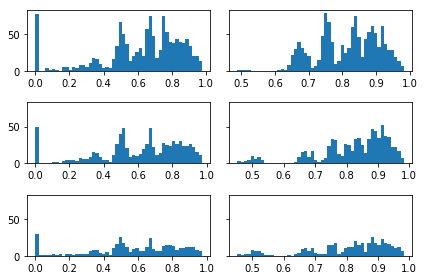

In [400]:
n_bins=50
fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True)
s=axs[0,0].hist(ss2_1, bins=n_bins)
s=axs[1,0].hist(ss2_2, bins=n_bins)
s=axs[2,0].hist(ss2_3, bins=n_bins)

s=axs[0,1].hist(ss1_1, bins=n_bins)
s=axs[1,1].hist(ss1_2, bins=n_bins)
s=axs[2,1].hist(ss1_3, bins=n_bins)

## Some notes:
- We found interesting examples for featuer selection in many Graphs(presented only one on above). These findings are easy to interpret by father-child or child-father relations. 
- In our ensemble study based on 100 graphs, simple histogram doens't provide meaniful results(at least not understood well for now).
- In our ensembale cauculation, for a general node i,  the distance L (1,or 2 or 3) measures the distance between the given  node to other nodes that are connected by father-child or child-father relation. For a given L and i, we can count the number of L-distant neibours. We input this number as the the number of features to be selected. In many cases(contrary to the specific example discussed on above),  the features selected by sklearn.feature_selection.SelectFromModel is not the features we count.

- We may try different way, e.g., force the selected features to be the ones we want to choose by simple counting, or, by counting the neighbours by <=L instead of =L. Possibly, we should differentiate father-child and child-father relation.  